In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader,Dataset
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/ROB498/modelnet10_normal_resampled.zip' -d '/content'

In [ ]:
!unzip  '/content/drive/MyDrive/ROB498/data.zip' -d '/content'

Archive:  /content/drive/MyDrive/ROB498/data.zip
  inflating: /content/data/point_cloud_Y.txt  
  inflating: /content/data/cls/train_data.npy  
  inflating: /content/data/point_cloud_X.txt  
  inflating: /content/data/seg/.DS_Store  
  inflating: /content/data/cls/.DS_Store  
   creating: /content/data/cls/.ipynb_checkpoints/
   creating: /content/data/seg/.ipynb_checkpoints/
  inflating: /content/data/cls/test_labels.npy  
  inflating: /content/data/seg/train_labels.npy  
  inflating: /content/data/cls/train_labels.npy  
  inflating: /content/data/seg/test_labels.npy  
  inflating: /content/data/cls/test_data.npy  
  inflating: /content/data/seg/test_data.npy  
  inflating: /content/data/generate_point_cloud.npz  
  inflating: /content/data/seg/train_data.npy  


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Dec  4 04:20:16 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    47W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Utils

In [ ]:
# CATEGORIES = {'1': 0, '2': 1, '3': 2, '4': 3, '5': 4, '6': 5}
# COLOR_MAP = {
#     0  : (47, 79, 79),
#     1  : (139, 69, 19),
#     2  : (34, 139, 34),
#     3  : (75, 0, 130),
#     4  : (255, 0, 0),
#     5  : (255, 255, 0)}
# def inference(model,dataloader,device='cuda'):
#   correct_point_clouds = []
#   false_point_clouds = []
#   index=0
#   for batch in dataloader:
#           point_cloud, labels = batch
#           point_cloud = point_cloud.to(device)
#           point_clouds = point_cloud[:,0::5,:].to(device).permute(0,2,1)
#           #point_clouds = point_clouds.to(device)
#           labels = labels[:,0::5].to(device).to(torch.long)

#           predictions = model.forward(point_clouds)
#           #print(point_clouds.shape)
#           #print(predictions.shape)
#           #print(labels.shape)
#           predictions = torch.argmax(predictions,dim=1)
#           #print(predictions.shape)

#           correct_mask = predictions==labels
#           false_mask = predictions!=labels
#           correct_points = point_clouds[0,:,correct_mask[0,:]]
#           correct_points = correct_points.cpu().data.numpy()

#           #print(correct_points.shape)
#           fig=plt.figure()
#           ax=fig.add_subplot(111,projection='3d')
#           #标题
#           plt.title('Correct')
#           label = labels[0,correct_mask[0,:]]
#           #利用xyz的值，生成每个点的相应坐标（x,y,z）
#           for i in range(6):
#             color = COLOR_MAP[i]
#             mask = label==i
#             points = correct_points[:,mask.cpu()].T
#             ax.scatter(points[:,0],points[:,1],points[:,2],marker='.',linewidth=0,alpha=1)
#           ax.set_xlabel('X Label')
#           ax.set_ylabel('Y Label')
#           ax.set_zlabel('Z Label')
#           plt.show()

#           false_points = point_clouds[0,:,false_mask[0,:]]
#           false_points = false_points.cpu().data.numpy()
#           fig=plt.figure()
#           ax=fig.add_subplot(111,projection='3d')
#           #标题
#           plt.title('False')
#           label = labels[0,false_mask[0,:]]
#           #利用xyz的值，生成每个点的相应坐标（x,y,z）
#           for i in range(6):
#             color = COLOR_MAP[i]
#             mask = label==i
#             points = false_points[:,mask.cpu()].T
#             ax.scatter(points[:,0],points[:,1],points[:,2],marker='.',linewidth=0,alpha=1)
#           ax.set_xlabel('X Label')
#           ax.set_ylabel('Y Label')
#           ax.set_zlabel('Z Label')
#           plt.show()
#           index = index+1
#           if(index>3):
#             break

## DataLoader

In [ ]:
def pc_normalize(pc):
    centroid = np.mean(pc, axis=0)
    pc = pc - centroid
    m = np.max(np.sqrt(np.sum(pc**2, axis=1)))
    pc = pc / m
    return pc


def farthest_point_sample(xyz,npoint):
    """
    Input:
        xyz: pointcloud data, [B, N, 3]
        npoint: number of samples
    Return:
        centroids: sampled pointcloud index, [B, npoint]
    """
    device = torch.device('cuda')#xyz.device
    B, N, C = xyz.shape
    centroids = torch.zeros(B, npoint, dtype=torch.long).to(device)
    distance = torch.ones(B, N).to(device) * 1e10
    farthest = torch.randint(0, N, (B,), dtype=torch.long).to(device)
    batch_indices = torch.arange(B, dtype=torch.long).to(device)
    for i in range(npoint):
        centroids[:, i] = farthest
        centroid = xyz[batch_indices, farthest, :].view(B, 1, 3)
        dist = torch.sum((xyz - centroid) ** 2, -1)
        distance = torch.min(distance, dist)
        farthest = torch.max(distance, -1)[1]
    return centroids


def square_distance(src, dst):
    """
    Calculate Euclid distance between each two points.
    src^T * dst = xn * xm + yn * ym + zn * zm；
    sum(src^2, dim=-1) = xn*xn + yn*yn + zn*zn;
    sum(dst^2, dim=-1) = xm*xm + ym*ym + zm*zm;
    dist = (xn - xm)^2 + (yn - ym)^2 + (zn - zm)^2
         = sum(src**2,dim=-1)+sum(dst**2,dim=-1)-2*src^T*dst

    Input:
        src: source points, [B, N, C]
        dst: target points, [B, M, C]

    Output:
        dist: per-point square distance, [B, N, M]
    """
    B, N, _ = src.shape
    _, M, _ = dst.shape
    dist = -2 * torch.matmul(src, dst.permute(0, 2, 1))
    dist += torch.sum(src ** 2, -1).view(B, N, 1)
    dist += torch.sum(dst ** 2, -1).view(B, 1, M)
    return dist

def knn_point(k, xyz, new_xyz):
    """
    K nearest neighborhood.

    Input:
        k: max sample number in local region
        xyz: all points, [B, N, C]
        new_xyz: query points, [B, S, C]

    Output:
        group_idx: grouped points index, [B, S, k]
    """
    sqrdists = square_distance(new_xyz, xyz)
    _, group_idx = torch.topk(sqrdists, k, dim=-1, largest=False, sorted=False)
    return group_idx

def index_points(points, idx):
    """
    Input:
        points: input points data, [B, N, C]
        idx: sample index data, [B, S]

    Output:
        new_points:, indexed points data, [B, S, C]
    """
    device = points.device
    B = points.shape[0]
    view_shape = list(idx.shape)
    view_shape[1:] = [1] * (len(view_shape) - 1)
    repeat_shape = list(idx.shape)
    repeat_shape[0] = 1
    batch_indices = torch.arange(B, dtype=torch.long).to(device).view(view_shape).repeat(repeat_shape)
    new_points = points[batch_indices, idx, :]
    return new_points

def sample_knn_group(s, k, coords, features):
    """
    Sampling by FPS and grouping by KNN.

    Input:
        s[int]: number of points to be sampled by FPS
        k[int]: number of points to be grouped into a neighbor by KNN
        coords[tensor]: input points coordinates data with size of [B, N, 3]
        features[tensor]: input points features data with size of [B, N, D]

    Returns:
        new_coords[tensor]: sampled and grouped points coordinates by FPS with size of [B, s, k, 3]
        new_features[tensor]: sampled and grouped points features by FPS with size of [B, s, k, 2D]
    """
    batch_size = coords.shape[0]
    coords = coords.contiguous()

    # FPS sampling
    fps_idx = farthest_point_sample(coords, s).long()  # [B, s]
    new_coords = index_points(coords, fps_idx)                         # [B, s, 3]
    new_features = index_points(features, fps_idx)                     # [B, s, D]

    # K-nn grouping
    idx = knn_point(k, coords, new_coords)                                             # [B, s, k]
    grouped_features = index_points(features, idx)                                      # [B, s, k, D]

    # Matrix sub
    grouped_features_norm = grouped_features - new_features.view(batch_size, s, 1, -1)  # [B, s, k, D]

    # Concat
    aggregated_features = torch.cat([grouped_features_norm, new_features.view(batch_size, s, 1, -1).repeat(1, 1, k, 1)], dim=-1)  # [B, s, k, 2D]
    return new_coords, aggregated_features
category = 10
modelnetshape_path = f'modelnet{category}_shape_names.txt'
modelnettrain_path = f'modelnet{category}_train.txt'
modelnettest_path = f'modelnet{category}_test.txt'
class ModelNetDataLoader(Dataset):
    def __init__(self, root, npoint=1024, split='train', uniform=False, normal_channel=True, cache_size=15000):
        self.root = root
        self.npoints = npoint
        self.uniform = uniform
        self.catfile = os.path.join(self.root,modelnetshape_path)

        self.cat = [line.rstrip() for line in open(self.catfile)]
        self.classes = dict(zip(self.cat, range(len(self.cat))))
        self.normal_channel = normal_channel

        shape_ids = {}
        shape_ids['train'] = [line.rstrip() for line in open(os.path.join(self.root, modelnettrain_path))]
        shape_ids['test'] = [line.rstrip() for line in open(os.path.join(self.root, modelnettest_path))]

        assert (split == 'train' or split == 'test')
        shape_names = ['_'.join(x.split('_')[0:-1]) for x in shape_ids[split]]
        # list of (shape_name, shape_txt_file_path) tuple
        self.datapath = [(shape_names[i], os.path.join(self.root, shape_names[i], shape_ids[split][i]) + '.txt') for i
                         in range(len(shape_ids[split]))]
        print('The size of %s data is %d'%(split,len(self.datapath)))

        self.cache_size = cache_size  # how many data points to cache in memory
        self.cache = {}  # from index to (point_set, cls) tuple

    def __len__(self):
        return len(self.datapath)

    def _get_item(self, index):
        if index in self.cache:
            point_set, cls = self.cache[index]
        else:
            fn = self.datapath[index]
            cls = self.classes[self.datapath[index][0]]
            cls = np.array([cls]).astype(np.int32)
            point_set = np.loadtxt(fn[1], delimiter=',').astype(np.float32)
            if self.uniform:
                point_set = farthest_point_sample(point_set, self.npoints)
            else:
                point_set = point_set[0:self.npoints,:]

            point_set[:, 0:3] = pc_normalize(point_set[:, 0:3])

            if not self.normal_channel:
                point_set = point_set[:, 0:3]

            if len(self.cache) < self.cache_size:
                self.cache[index] = (point_set, cls)

        return point_set, cls

    def __getitem__(self, index):
        return self._get_item(index)


## Dataloader For Segmentation

In [ ]:
class cocoDataset(Dataset):
    def __init__(self, path, train=True):
        self.path = path
        if train:
            self.data_path = self.path + "/train_data.npy"
            self.label_path = self.path + "/train_labels.npy"
        else:
            self.data_path = self.path + "/test_data.npy"
            self.label_path = self.path + "/test_labels.npy"
        self.data = torch.from_numpy(np.load(self.data_path))[:,0:1024,:]
        self.label = torch.from_numpy(np.load(self.label_path)).to(torch.long)[:,0:1024]
    def __len__(self):
        return self.data.size()[0]

    def __getitem__(self, idx):
        return self.data[idx], self.label[idx]

def get_data_loader(path, batch_size, train=True):
    """
    Creates training and test data loaders
    """
    dataset = cocoDataset(path, train)
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=train, num_workers=1)


    return dataloader

## Self Attention

In [ ]:
class SelfAttention(nn.Module):
    def __init__(self,in_channel):
        super(SelfAttention,self).__init__()
        self.in_channel = in_channel
        self.q_conv = nn.Conv1d(in_channel, in_channel // 4, 1, bias=False)
        self.k_conv = nn.Conv1d(in_channel, in_channel // 4, 1, bias=False)
        self.v_conv = nn.Conv1d(in_channel, in_channel, 1)

        self.q_conv.weight = self.k_conv.weight
        self.trans_conv = nn.Conv1d(in_channel, in_channel, 1)
        self.after_norm = nn.BatchNorm1d(in_channel)
        self.activate = nn.ReLU()
        self.softmax = nn.Softmax(dim=-1)


    def forward(self,x):
        x_q = self.q_conv(x).permute(0, 2, 1)
        x_k = self.k_conv(x)
        x_v = self.v_conv(x)

        div = math.sqrt(self.in_channel // 4)
        energy = torch.bmm(x_q, x_k) / div

        attention = self.softmax(energy)

        x_s = torch.bmm(x_v, attention)
        x_s = self.activate(self.after_norm(self.trans_conv(x_s)))

        x = x + x_s
        return x

## Off Attention

In [ ]:
class OffSetAttention(nn.Module):
    def __init__(self,in_channel):
        super(OffSetAttention,self).__init__()
        self.in_channel = in_channel
        self.q_conv = nn.Conv1d(in_channel, in_channel // 4, 1, bias=False)
        self.k_conv = nn.Conv1d(in_channel, in_channel // 4, 1, bias=False)
        self.v_conv = nn.Conv1d(in_channel, in_channel, 1)

        self.q_conv.weight = self.k_conv.weight
        self.trans_conv = nn.Conv1d(in_channel, in_channel, 1)
        self.after_norm = nn.BatchNorm1d(in_channel)
        self.activate = nn.ReLU()
        self.softmax = nn.Softmax(dim=-1)

    def forward(self,x):
        x_q = self.q_conv(x).permute(0, 2, 1)
        x_k = self.k_conv(x)
        x_v = self.v_conv(x)

        energy = torch.bmm(x_q, x_k)
        attention_raw = self.softmax(energy)

        sum_atten_raw = 1e-9 + attention_raw.sum(dim=1, keepdims=True)
        attention = attention_raw / sum_atten_raw

        x_a = torch.bmm(x_v, attention)
        x_d = x - x_a
        x_r = self.activate(self.after_norm(self.trans_conv(x_d)))
        x = x + x_r

        return x

## Embedding and NeighborEmbedding Block

In [ ]:
class Embedding(nn.Module):
    def __init__(self,in_channel):
        super(Embedding,self).__init__()
        self.lbr0 = nn.Sequential(
                    nn.Conv1d(in_channels=in_channel,out_channels=128,kernel_size=1),
                    nn.BatchNorm1d(128),
                    nn.ReLU()
                )

        self.lbr1 = nn.Sequential(
                    nn.Conv1d(in_channels=128,out_channels=128,kernel_size=1),
                    nn.BatchNorm1d(128),
                    nn.ReLU()
                )

    def forward(self,x):
        x1 = self.lbr0(x)
        x2 = self.lbr1(x1)
        return x2

class NeighborEmbedding(nn.Module):
    def __init__(self,in_channel):
        super(NeighborEmbedding, self).__init__()

        self.conv1 = nn.Conv1d(in_channel, 64, kernel_size=1, bias=False)
        self.conv2 = nn.Conv1d(64, 64, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(64)

        self.sg1 = SampleGroup(s=512,k=32,in_channel=128, out_channel=128)
        self.sg2 = SampleGroup(s=256,k=32,in_channel=256, out_channel=256)

    def forward(self, x):
        """
        Input:
            x: [B, 6, N]
        """
        xyz = x.permute(0, 2, 1)[:,:,0:3]  # [B, N ,3]

        features = F.relu(self.bn1(self.conv1(x)))        # [B, 64, N]
        features = F.relu(self.bn2(self.conv2(features))) # [B, 64, N]

        xyz1, features1 = self.sg1(features, xyz)         # [B, 128, 512]
        _, features2 = self.sg2(features1, xyz1)
        return features2

## Sample Group Block

In [ ]:
class SampleGroup(nn.Module):
    def __init__(self,s,k,in_channel,out_channel):
        super(SampleGroup,self).__init__()
        self.s = s
        self.k = k
        self.conv1 = nn.Conv1d(in_channel, out_channel, kernel_size=1, bias=False)
        self.conv2 = nn.Conv1d(out_channel, out_channel, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channel)
        self.bn2 = nn.BatchNorm1d(out_channel)

    def forward(self,x,coordinates):
        x = x.permute(0, 2, 1)
        new_xyz, new_feature = sample_knn_group(self.s, self.k, coordinates, x)
        b, s, k, d = new_feature.size()
        new_feature = new_feature.permute(0, 1, 3, 2).reshape(-1, d, k)
        batch_size = new_feature.size(0)
        new_feature = F.relu(self.bn1(self.conv1(new_feature)))
        new_feature = F.relu(self.bn2(self.conv2(new_feature)))
        new_feature = F.adaptive_max_pool1d(new_feature, 1).view(batch_size, -1)
        new_feature = new_feature.reshape(b, s, -1).permute(0, 2, 1)
        return new_xyz, new_feature

## Test

In [ ]:
def test(test_dataloader,model,epoch,device,task):
    model.eval()
    correct_obj = 0
    num_obj = 0
    classes = 6
    for batch in test_dataloader:
        point_clouds, labels = batch
        point_clouds = torch.permute(point_clouds,(0,2,1)).to(device).float()
        #point_clouds = point_clouds.to(device)
        labels = labels.view(-1).to(device).to(torch.long)
        #########################################
        #############YOUR CODE HERE##############
        #########################################
        if task=='classification':
          predictions = model(point_clouds)
        else:
          predictions = model.forward(point_clouds,labels.to(torch.float)).permute(0,2,1).reshape([-1,classes])
        predictions = torch.argmax(predictions,dim=1)
        correct_obj += torch.sum(predictions==labels).item()
        num_obj += len(labels)
        #print("num_obj num_correct",num_obj,correct_obj)
        #########################################
    # Compute Accuracy of Test Dataset
    accuracy = correct_obj / num_obj

    return accuracy

## Train

In [ ]:
def train(train_dataloader,model,opt,epoch,device,task):
    model.train()
    step = epoch*len(train_dataloader)
    epoch_loss = 0
    classes = 6
    for i,batch in enumerate(train_dataloader):
        point_clouds,labels = batch
        point_clouds = torch.permute(point_clouds,(0,2,1)).to(device).float()
        labels = labels.view(-1).to(device).to(torch.long)
        if task=='classification':
          output = model(point_clouds)
        else:
          output = model.forward(point_clouds,labels.to(torch.float)).permute(0,2,1).reshape([-1,classes])

        #output = model.forward(point_clouds,labels)
        #print(output.shape)
        #print(labels.shape)
        opt.zero_grad()
        criterion = nn.CrossEntropyLoss()
        loss = criterion(output, labels)
        # print(t, loss.item())
        loss.backward()
        opt.step()
        epoch_loss += loss

    return epoch_loss



# Naive PCT

## Classify

In [ ]:
class NaivePCTransCls(nn.Module):
    def __init__(self,in_channel=3,out_channel=6,points_num=1024,task='classification'):
        super(NaivePCTransCls,self).__init__()
        self.in_channel = in_channel
        self.out_channel = out_channel
        self.task = task

        self.embed = Embedding(in_channel)
        #self.sg = SampleGroup(in_channel)
        self.sa1 = SelfAttention(128)
        self.sa2 = SelfAttention(128)
        self.sa3 = SelfAttention(128)
        self.sa4 = SelfAttention(128)

        self.lbr1 = nn.Sequential(
                    nn.Conv1d(in_channels=512,out_channels=1024,kernel_size=1),
                    nn.BatchNorm1d(1024),
                    nn.ReLU()
                )

        #self.m = nn.MaxPool1d(1024,1)
        #self.avg = nn.MaxPool1d(1024,1)
        # for classification
        self.lbrd1 = nn.Sequential(
                    nn.Conv1d(in_channels=2048,out_channels=256,kernel_size=1),
                    nn.BatchNorm1d(256),
                    nn.ReLU(),
                    nn.Dropout()
                )

        self.lbrd2 = nn.Sequential(
                    nn.Conv1d(in_channels=256,out_channels=256,kernel_size=1),
                    nn.BatchNorm1d(256),
                    nn.ReLU(),
                    nn.Dropout()
                )

        self.l1 = nn.Conv1d(in_channels=256,out_channels=out_channel,kernel_size=1)

        # for segmentation
        self.lbrd3 = nn.Sequential(
                    nn.Conv1d(in_channels=3072,out_channels=256,kernel_size=1),
                    nn.BatchNorm1d(256),
                    nn.ReLU(),
                    nn.Dropout()
                    )

        self.lbr2 = nn.Sequential(
                    nn.Conv1d(in_channels=256,out_channels=256,kernel_size=1),
                    nn.BatchNorm1d(256),
                    nn.ReLU()
                )


    def forward(self,x):
        x0 = self.embed(x)
        x1 = self.sa1(x0)
        x2 = self.sa2(x1)
        x3 = self.sa3(x2)
        x4 = self.sa4(x3)
        x5 = torch.concatenate((x1,x2,x3,x4),1)
        x6 = self.lbr1(x5)#point feature

        #if self.task=='classification':
        x7 = torch.max(x6,-1)[0]
        x8 = torch.mean(x6,-1)
        x9 = torch.concatenate((x7,x8),1)
        x9 = x9.view(x9.shape[0],x9.shape[1],1)
        x10 = self.lbrd1(x9)
        x11 = self.lbrd2(x10)

        output = self.l1(x11)
        #print("output",output.shape)
        return output.view(output.shape[0],-1)


In [ ]:
losses = []
accuracy = []
def main():
    NUM_CLASSES = 10
    NUM_FEATURES = 6
    NUM_TRAIN_POINTS = 1024

    TASK = 'classification'
    model_save_path = os.path.join(os. getcwd(), 'drive/MyDrive/ROB498/model/best_classify_model10_NAIVE_normal.pt')
    learning_rate = 0.001
    #path = 'data/cls'
    Batch_size = 256
    num_epochs = 100
    if TASK=='classification':
      model = NaivePCTransCls(NUM_FEATURES,NUM_CLASSES,NUM_TRAIN_POINTS,TASK)
    else:
      model= NaivePCTransSeg(NUM_FEATURES,NUM_CLASSES,NUM_TRAIN_POINTS,TASK)
    device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
    #opt = optim.Adam(model.parameters(),learning_rate)
    opt = optim.SGD(model.parameters(),learning_rate,momentum=0.5)
    #path = os.path.join(os.getcwd(),'drive/MyDrive/ROB498/modelnet10_normal_resampled/')
    path = '/content/modelnet10_normal_resampled/'
    train_data = ModelNetDataLoader(root=path,npoint=NUM_TRAIN_POINTS, split='train', uniform=False, normal_channel=True)
    train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=Batch_size, shuffle=True)

    test_data = ModelNetDataLoader(root=path,npoint=NUM_TRAIN_POINTS, split='test', uniform=False, normal_channel=True)
    test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=Batch_size, shuffle=True)

    #train_dataloader = get_data_loader(path,batch_size,True)
    #test_dataloader = get_data_loader(path,batch_size,False)

    model = model.to(device)

    best_accuracy = -1
    for epoch in tqdm(range(num_epochs)):
        train_epoch_loss = train(train_dataloader,model,opt,epoch,device,TASK)
        test_accuracy = test(test_dataloader,model,epoch,device,TASK)
        #print(train_epoch_loss)
        losses.append(train_epoch_loss.item())
        accuracy.append(test_accuracy)
        print ("epoch: {}   train loss: {:.4f}   test accuracy: {:.4f}".format(epoch, train_epoch_loss, test_accuracy))
        if test_accuracy>best_accuracy:
           best_accuracy = test_accuracy
           torch.save(model.state_dict(),model_save_path)
    epoches = range(len(losses))
    plt.plot(epoches,losses,label='loss')
    plt.legend()
    plt.show()

    plt.plot(epoches,accuracy,label='accuracy')
    plt.legend()
    plt.show()

The size of train data is 3991
The size of test data is 908


  1%|          | 1/100 [00:45<1:15:30, 45.76s/it]

epoch: 0   train loss: 35.9522   test accuracy: 0.1101


  2%|▏         | 2/100 [00:50<35:41, 21.85s/it]  

epoch: 1   train loss: 30.5440   test accuracy: 0.1101


  3%|▎         | 3/100 [00:55<22:58, 14.21s/it]

epoch: 2   train loss: 26.8176   test accuracy: 0.1101


  4%|▍         | 4/100 [01:01<17:01, 10.64s/it]

epoch: 3   train loss: 24.4932   test accuracy: 0.4769


  5%|▌         | 5/100 [01:06<13:43,  8.67s/it]

epoch: 4   train loss: 22.4020   test accuracy: 0.5584


  6%|▌         | 6/100 [01:11<11:42,  7.48s/it]

epoch: 5   train loss: 20.6301   test accuracy: 0.6167


  7%|▋         | 7/100 [01:16<10:23,  6.71s/it]

epoch: 6   train loss: 20.9899   test accuracy: 0.6079


  8%|▊         | 8/100 [01:21<09:32,  6.22s/it]

epoch: 7   train loss: 18.8817   test accuracy: 0.6443


  9%|▉         | 9/100 [01:26<08:56,  5.90s/it]

epoch: 8   train loss: 17.7689   test accuracy: 0.6586


 10%|█         | 10/100 [01:32<08:30,  5.68s/it]

epoch: 9   train loss: 16.8210   test accuracy: 0.6784


 11%|█         | 11/100 [01:37<08:11,  5.53s/it]

epoch: 10   train loss: 16.2898   test accuracy: 0.6850


 12%|█▏        | 12/100 [01:42<07:56,  5.41s/it]

epoch: 11   train loss: 16.1782   test accuracy: 0.6795


 13%|█▎        | 13/100 [01:47<07:45,  5.35s/it]

epoch: 12   train loss: 15.4904   test accuracy: 0.7015


 14%|█▍        | 14/100 [01:52<07:35,  5.30s/it]

epoch: 13   train loss: 14.7245   test accuracy: 0.7247


 15%|█▌        | 15/100 [01:58<07:27,  5.27s/it]

epoch: 14   train loss: 14.3101   test accuracy: 0.7467


 16%|█▌        | 16/100 [02:03<07:20,  5.25s/it]

epoch: 15   train loss: 13.7283   test accuracy: 0.7863


 17%|█▋        | 17/100 [02:08<07:13,  5.22s/it]

epoch: 16   train loss: 13.7589   test accuracy: 0.7379


 18%|█▊        | 18/100 [02:13<07:06,  5.20s/it]

epoch: 17   train loss: 13.1952   test accuracy: 0.7632


 19%|█▉        | 19/100 [02:18<07:01,  5.20s/it]

epoch: 18   train loss: 12.5091   test accuracy: 0.7952


 20%|██        | 20/100 [02:23<06:54,  5.19s/it]

epoch: 19   train loss: 12.3478   test accuracy: 0.7830


 21%|██        | 21/100 [02:29<06:48,  5.18s/it]

epoch: 20   train loss: 11.7365   test accuracy: 0.7698


 22%|██▏       | 22/100 [02:34<06:43,  5.18s/it]

epoch: 21   train loss: 11.5554   test accuracy: 0.8062


 23%|██▎       | 23/100 [02:39<06:38,  5.17s/it]

epoch: 22   train loss: 11.0023   test accuracy: 0.7952


 24%|██▍       | 24/100 [02:44<06:33,  5.17s/it]

epoch: 23   train loss: 10.6449   test accuracy: 0.8205


 25%|██▌       | 25/100 [02:49<06:27,  5.17s/it]

epoch: 24   train loss: 10.8307   test accuracy: 0.8062


 26%|██▌       | 26/100 [02:54<06:23,  5.18s/it]

epoch: 25   train loss: 10.6052   test accuracy: 0.8249


 27%|██▋       | 27/100 [03:00<06:17,  5.17s/it]

epoch: 26   train loss: 10.3420   test accuracy: 0.7841


 28%|██▊       | 28/100 [03:05<06:12,  5.17s/it]

epoch: 27   train loss: 10.4773   test accuracy: 0.8227


 29%|██▉       | 29/100 [03:10<06:07,  5.18s/it]

epoch: 28   train loss: 9.8152   test accuracy: 0.8326


 30%|███       | 30/100 [03:15<06:01,  5.17s/it]

epoch: 29   train loss: 9.5913   test accuracy: 0.8293


 31%|███       | 31/100 [03:20<05:57,  5.18s/it]

epoch: 30   train loss: 9.3143   test accuracy: 0.8447


 32%|███▏      | 32/100 [03:26<05:52,  5.19s/it]

epoch: 31   train loss: 8.9405   test accuracy: 0.8502


 33%|███▎      | 33/100 [03:31<05:48,  5.20s/it]

epoch: 32   train loss: 8.7962   test accuracy: 0.8513


 34%|███▍      | 34/100 [03:36<05:43,  5.20s/it]

epoch: 33   train loss: 8.5458   test accuracy: 0.8524


 35%|███▌      | 35/100 [03:41<05:37,  5.19s/it]

epoch: 34   train loss: 8.5256   test accuracy: 0.7665


 36%|███▌      | 36/100 [03:46<05:31,  5.18s/it]

epoch: 35   train loss: 8.5512   test accuracy: 0.8403


 37%|███▋      | 37/100 [03:52<05:26,  5.19s/it]

epoch: 36   train loss: 8.2203   test accuracy: 0.8656


 38%|███▊      | 38/100 [03:57<05:21,  5.18s/it]

epoch: 37   train loss: 7.9603   test accuracy: 0.8568


 39%|███▉      | 39/100 [04:02<05:15,  5.18s/it]

epoch: 38   train loss: 8.2740   test accuracy: 0.8480


 40%|████      | 40/100 [04:07<05:10,  5.17s/it]

epoch: 39   train loss: 8.6933   test accuracy: 0.8238


 41%|████      | 41/100 [04:12<05:05,  5.17s/it]

epoch: 40   train loss: 8.2819   test accuracy: 0.8535


 42%|████▏     | 42/100 [04:17<05:00,  5.18s/it]

epoch: 41   train loss: 7.8742   test accuracy: 0.8722


 43%|████▎     | 43/100 [04:23<04:55,  5.19s/it]

epoch: 42   train loss: 7.7077   test accuracy: 0.8767


 44%|████▍     | 44/100 [04:28<04:50,  5.18s/it]

epoch: 43   train loss: 7.3170   test accuracy: 0.8722


 45%|████▌     | 45/100 [04:33<04:44,  5.18s/it]

epoch: 44   train loss: 7.1439   test accuracy: 0.8767


 46%|████▌     | 46/100 [04:38<04:39,  5.18s/it]

epoch: 45   train loss: 7.2554   test accuracy: 0.8877


 47%|████▋     | 47/100 [04:43<04:34,  5.18s/it]

epoch: 46   train loss: 7.2098   test accuracy: 0.8811


 48%|████▊     | 48/100 [04:48<04:28,  5.17s/it]

epoch: 47   train loss: 7.2060   test accuracy: 0.8458


 49%|████▉     | 49/100 [04:54<04:23,  5.17s/it]

epoch: 48   train loss: 7.1474   test accuracy: 0.8634


 50%|█████     | 50/100 [04:59<04:18,  5.16s/it]

epoch: 49   train loss: 7.3133   test accuracy: 0.6090


 51%|█████     | 51/100 [05:04<04:12,  5.16s/it]

epoch: 50   train loss: 9.3412   test accuracy: 0.8249


 52%|█████▏    | 52/100 [05:09<04:07,  5.16s/it]

epoch: 51   train loss: 8.0641   test accuracy: 0.8425


 53%|█████▎    | 53/100 [05:14<04:02,  5.16s/it]

epoch: 52   train loss: 7.5555   test accuracy: 0.8568


 54%|█████▍    | 54/100 [05:19<03:57,  5.16s/it]

epoch: 53   train loss: 7.2718   test accuracy: 0.8623


 55%|█████▌    | 55/100 [05:25<03:52,  5.16s/it]

epoch: 54   train loss: 7.0821   test accuracy: 0.8634


 56%|█████▌    | 56/100 [05:30<03:46,  5.16s/it]

epoch: 55   train loss: 7.2813   test accuracy: 0.8689


 57%|█████▋    | 57/100 [05:35<03:41,  5.16s/it]

epoch: 56   train loss: 6.7333   test accuracy: 0.8656


 58%|█████▊    | 58/100 [05:40<03:36,  5.16s/it]

epoch: 57   train loss: 6.7489   test accuracy: 0.8414


 59%|█████▉    | 59/100 [05:45<03:31,  5.16s/it]

epoch: 58   train loss: 6.6435   test accuracy: 0.8667


 60%|██████    | 60/100 [05:50<03:26,  5.16s/it]

epoch: 59   train loss: 6.4666   test accuracy: 0.8689


 61%|██████    | 61/100 [05:55<03:21,  5.16s/it]

epoch: 60   train loss: 6.1150   test accuracy: 0.8822


 62%|██████▏   | 62/100 [06:01<03:16,  5.16s/it]

epoch: 61   train loss: 6.1240   test accuracy: 0.8744


 63%|██████▎   | 63/100 [06:06<03:10,  5.16s/it]

epoch: 62   train loss: 5.8500   test accuracy: 0.8789


 64%|██████▍   | 64/100 [06:11<03:05,  5.16s/it]

epoch: 63   train loss: 5.5705   test accuracy: 0.8811


 65%|██████▌   | 65/100 [06:16<03:00,  5.16s/it]

epoch: 64   train loss: 5.7299   test accuracy: 0.8811


 66%|██████▌   | 66/100 [06:21<02:55,  5.16s/it]

epoch: 65   train loss: 5.7776   test accuracy: 0.8789


 67%|██████▋   | 67/100 [06:26<02:50,  5.16s/it]

epoch: 66   train loss: 6.1300   test accuracy: 0.8700


 68%|██████▊   | 68/100 [06:32<02:45,  5.16s/it]

epoch: 67   train loss: 6.2094   test accuracy: 0.8811


 69%|██████▉   | 69/100 [06:37<02:39,  5.16s/it]

epoch: 68   train loss: 5.8424   test accuracy: 0.8767


 70%|███████   | 70/100 [06:42<02:34,  5.16s/it]

epoch: 69   train loss: 5.7035   test accuracy: 0.8811


 71%|███████   | 71/100 [06:47<02:29,  5.16s/it]

epoch: 70   train loss: 5.5248   test accuracy: 0.8822


 72%|███████▏  | 72/100 [06:52<02:24,  5.16s/it]

epoch: 71   train loss: 5.5223   test accuracy: 0.8822


 73%|███████▎  | 73/100 [06:57<02:19,  5.16s/it]

epoch: 72   train loss: 5.3633   test accuracy: 0.8877


 74%|███████▍  | 74/100 [07:03<02:14,  5.17s/it]

epoch: 73   train loss: 5.2622   test accuracy: 0.8888


 75%|███████▌  | 75/100 [07:08<02:09,  5.18s/it]

epoch: 74   train loss: 5.2150   test accuracy: 0.8987


 76%|███████▌  | 76/100 [07:13<02:04,  5.18s/it]

epoch: 75   train loss: 5.0225   test accuracy: 0.8987


 77%|███████▋  | 77/100 [07:18<01:59,  5.17s/it]

epoch: 76   train loss: 4.9490   test accuracy: 0.8965


 78%|███████▊  | 78/100 [07:23<01:53,  5.17s/it]

epoch: 77   train loss: 4.9356   test accuracy: 0.8954


 79%|███████▉  | 79/100 [07:29<01:48,  5.18s/it]

epoch: 78   train loss: 4.8336   test accuracy: 0.9009


 80%|████████  | 80/100 [07:34<01:43,  5.17s/it]

epoch: 79   train loss: 4.7177   test accuracy: 0.8976


 81%|████████  | 81/100 [07:39<01:38,  5.17s/it]

epoch: 80   train loss: 4.9567   test accuracy: 0.8877


 82%|████████▏ | 82/100 [07:44<01:33,  5.17s/it]

epoch: 81   train loss: 5.0244   test accuracy: 0.8987


 83%|████████▎ | 83/100 [07:49<01:27,  5.17s/it]

epoch: 82   train loss: 4.8092   test accuracy: 0.8998


 84%|████████▍ | 84/100 [07:54<01:22,  5.16s/it]

epoch: 83   train loss: 4.7110   test accuracy: 0.8998


 85%|████████▌ | 85/100 [07:59<01:17,  5.16s/it]

epoch: 84   train loss: 4.6053   test accuracy: 0.8932


 86%|████████▌ | 86/100 [08:05<01:12,  5.16s/it]

epoch: 85   train loss: 4.4270   test accuracy: 0.8987


 87%|████████▋ | 87/100 [08:10<01:07,  5.17s/it]

epoch: 86   train loss: 4.4868   test accuracy: 0.8899


 88%|████████▊ | 88/100 [08:15<01:02,  5.17s/it]

epoch: 87   train loss: 4.8816   test accuracy: 0.8866


 89%|████████▉ | 89/100 [08:20<00:56,  5.17s/it]

epoch: 88   train loss: 4.5917   test accuracy: 0.8833


 90%|█████████ | 90/100 [08:25<00:51,  5.17s/it]

epoch: 89   train loss: 4.4012   test accuracy: 0.8965


 91%|█████████ | 91/100 [08:30<00:46,  5.17s/it]

epoch: 90   train loss: 4.4813   test accuracy: 0.8965


 92%|█████████▏| 92/100 [08:36<00:41,  5.16s/it]

epoch: 91   train loss: 4.3375   test accuracy: 0.8998


 93%|█████████▎| 93/100 [08:41<00:36,  5.16s/it]

epoch: 92   train loss: 4.2041   test accuracy: 0.8899


 94%|█████████▍| 94/100 [08:46<00:30,  5.16s/it]

epoch: 93   train loss: 4.2520   test accuracy: 0.8877


 95%|█████████▌| 95/100 [08:51<00:25,  5.16s/it]

epoch: 94   train loss: 4.2541   test accuracy: 0.8899


 96%|█████████▌| 96/100 [08:56<00:20,  5.17s/it]

epoch: 95   train loss: 4.1470   test accuracy: 0.9031


 97%|█████████▋| 97/100 [09:01<00:15,  5.17s/it]

epoch: 96   train loss: 4.2307   test accuracy: 0.8954


 98%|█████████▊| 98/100 [09:07<00:10,  5.17s/it]

epoch: 97   train loss: 4.2321   test accuracy: 0.8844


 99%|█████████▉| 99/100 [09:12<00:05,  5.16s/it]

epoch: 98   train loss: 4.1766   test accuracy: 0.8954


100%|██████████| 100/100 [09:17<00:00,  5.57s/it]

epoch: 99   train loss: 3.8583   test accuracy: 0.8987


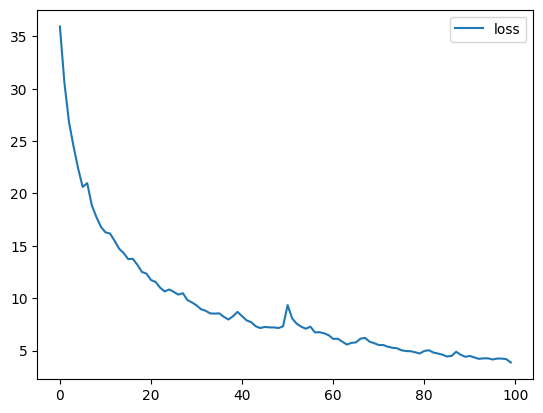

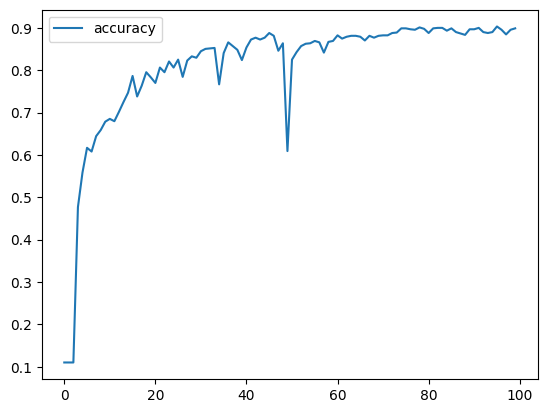

In [ ]:
main()

## Segmentation

In [ ]:
class NaivePCTransSeg(nn.Module):
    def __init__(self,in_channel=3,out_channel=6,points_num=1024,task='segmentation'):
        super(NaivePCTransSeg,self).__init__()
        self.in_channel = in_channel
        self.out_channel = out_channel
        self.task = task

        self.embed = Embedding(in_channel)

        self.sa1 = SelfAttention(128)
        self.sa2 = SelfAttention(128)
        self.sa3 = SelfAttention(128)
        self.sa4 = SelfAttention(128)

        self.lbr1 = nn.Sequential(
                    nn.Conv1d(in_channels=512,out_channels=1024,kernel_size=1),
                    nn.BatchNorm1d(1024),
                    nn.ReLU()
                )

        #self.m = nn.MaxPool1d(1024,1)
        #self.avg = nn.MaxPool1d(1024,1)
        # for classification
        self.lbrd1 = nn.Sequential(
                    nn.Conv1d(in_channels=2048,out_channels=256,kernel_size=1),
                    nn.BatchNorm1d(256),
                    nn.ReLU(),
                    nn.Dropout()
                )

        self.lbrd2 = nn.Sequential(
                    nn.Conv1d(in_channels=256,out_channels=256,kernel_size=1),
                    nn.BatchNorm1d(256),
                    nn.ReLU(),
                    nn.Dropout()
                )

        self.l1 = nn.Conv1d(in_channels=256,out_channels=out_channel,kernel_size=1)

        # for segmentation
        self.lbrd3 = nn.Sequential(
                    nn.Conv1d(in_channels=3072,out_channels=256,kernel_size=1),
                    nn.BatchNorm1d(256),
                    nn.ReLU(),
                    nn.Dropout()
                    )

        self.lbrd4 = nn.Sequential(
                    nn.Conv1d(in_channels=3136,out_channels=512,kernel_size=1),
                    nn.BatchNorm1d(512),
                    nn.ReLU(),
                    nn.Dropout()
                )
        self.lbr2 = nn.Sequential(
                    nn.Conv1d(in_channels=512,out_channels=256,kernel_size=1),
                    nn.BatchNorm1d(256),
                    nn.ReLU()
                )
        self.Conv1 = nn.Conv1d(256,self.out_channel,1)

        self.label_lbr = nn.Sequential(
                    nn.Conv1d(in_channels=1,out_channels=64,kernel_size=1),
                    nn.BatchNorm1d(64),
                    nn.ReLU(),
                    )

    def forward(self,x,labels):
        B,C,N = x.size()
        x0 = self.embed(x)
        x1 = self.sa1(x0)
        x2 = self.sa2(x1)
        x3 = self.sa3(x2)
        x4 = self.sa4(x3)
        x5 = torch.concatenate((x1,x2,x3,x4),1)
        x6 = self.lbr1(x5)#point feature
        #print(x6.shape)

        x_max = torch.max(x6,dim=-1)[0]
        x_mean = torch.mean(x6,dim=-1)
        x_max_features = x_max.unsqueeze(-1).repeat(1,1,N)
        x_mean_features = x_mean.unsqueeze(-1).repeat(1,1,N)
        labels_features = self.label_lbr(labels.view(B,1,N))
        x7 = torch.cat([x6,x_max_features,x_mean_features,labels_features],1)
        #print(x7.shape)
        x8 = self.lbrd4(x7)
        x9 = self.lbr2(x8)
        x10 = self.Conv1(x9)
        return x10


In [ ]:
losses = []
accuracy = []
def main():
    NUM_CLASSES = 6
    NUM_FEATURES = 3
    NUM_TRAIN_POINTS = 1024

    TASK = 'segmentation'
    model_save_path = os.path.join(os. getcwd(), 'drive/MyDrive/ROB498/model/best_segmentation_model10_NAIVE_normal.pt')
    learning_rate = 0.001
    Batch_size = 16
    num_epochs = 50
    if TASK=='classification':
      model = NaivePCTransCls(NUM_FEATURES,NUM_CLASSES,NUM_TRAIN_POINTS,TASK)
    else:
      model= NaivePCTransSeg(NUM_FEATURES,NUM_CLASSES,NUM_TRAIN_POINTS,TASK)
    device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
    #opt = optim.Adam(model.parameters(),learning_rate)
    opt = optim.SGD(model.parameters(),learning_rate,momentum=0.5)
    #path = os.path.join(os.getcwd(),'drive/MyDrive/ROB498/modelnet10_normal_resampled/')
    path = '/content/data/seg/'
    train_dataloader = get_data_loader(path,Batch_size, True)
    test_dataloader = get_data_loader(path,Batch_size, False)
    model = model.to(device)

    best_accuracy = -1
    for epoch in tqdm(range(num_epochs)):
        train_epoch_loss = train(train_dataloader,model,opt,epoch,device,TASK)
        test_accuracy = test(test_dataloader,model,epoch,device,TASK)
        #print(train_epoch_loss)
        losses.append(train_epoch_loss.item())
        accuracy.append(test_accuracy)
        print ("epoch: {}   train loss: {:.4f}   test accuracy: {:.4f}".format(epoch, train_epoch_loss, test_accuracy))
        if test_accuracy>best_accuracy:
           best_accuracy = test_accuracy
           torch.save(model.state_dict(),model_save_path)
    epoches = range(len(losses))
    plt.plot(epoches,losses,label='loss')
    plt.legend()
    plt.show()

    plt.plot(epoches,accuracy,label='accuracy')
    plt.legend()
    plt.show()

  2%|▏         | 1/50 [00:05<04:43,  5.78s/it]

epoch: 0   train loss: 389.2282   test accuracy: 0.5379


  4%|▍         | 2/50 [00:11<04:35,  5.74s/it]

epoch: 1   train loss: 325.1761   test accuracy: 0.6781


  6%|▌         | 3/50 [00:17<04:29,  5.74s/it]

epoch: 2   train loss: 220.4861   test accuracy: 0.8316


  8%|▊         | 4/50 [00:22<04:23,  5.73s/it]

epoch: 3   train loss: 161.6739   test accuracy: 0.8362


 10%|█         | 5/50 [00:28<04:18,  5.74s/it]

epoch: 4   train loss: 132.0418   test accuracy: 0.8830


 12%|█▏        | 6/50 [00:34<04:12,  5.73s/it]

epoch: 5   train loss: 111.3126   test accuracy: 0.8646


 14%|█▍        | 7/50 [00:40<04:06,  5.73s/it]

epoch: 6   train loss: 95.6365   test accuracy: 0.9077


 16%|█▌        | 8/50 [00:45<04:01,  5.74s/it]

epoch: 7   train loss: 76.1043   test accuracy: 0.9495


 18%|█▊        | 9/50 [00:51<03:54,  5.71s/it]

epoch: 8   train loss: 64.1399   test accuracy: 0.9317


 20%|██        | 10/50 [00:57<03:48,  5.72s/it]

epoch: 9   train loss: 46.9115   test accuracy: 0.9688


 22%|██▏       | 11/50 [01:03<03:43,  5.72s/it]

epoch: 10   train loss: 36.9190   test accuracy: 0.9776


 24%|██▍       | 12/50 [01:08<03:37,  5.71s/it]

epoch: 11   train loss: 31.7958   test accuracy: 0.9759


 26%|██▌       | 13/50 [01:14<03:31,  5.72s/it]

epoch: 12   train loss: 28.9619   test accuracy: 0.9818


 28%|██▊       | 14/50 [01:20<03:26,  5.73s/it]

epoch: 13   train loss: 25.6430   test accuracy: 0.9835


 30%|███       | 15/50 [01:25<03:20,  5.73s/it]

epoch: 14   train loss: 23.0838   test accuracy: 0.9883


 32%|███▏      | 16/50 [01:31<03:14,  5.73s/it]

epoch: 15   train loss: 21.2631   test accuracy: 0.9891


 34%|███▍      | 17/50 [01:37<03:09,  5.74s/it]

epoch: 16   train loss: 19.4876   test accuracy: 0.9911


 36%|███▌      | 18/50 [01:43<03:03,  5.75s/it]

epoch: 17   train loss: 17.7444   test accuracy: 0.9937


 38%|███▊      | 19/50 [01:48<02:58,  5.75s/it]

epoch: 18   train loss: 16.5971   test accuracy: 0.9944


 40%|████      | 20/50 [01:54<02:52,  5.74s/it]

epoch: 19   train loss: 15.4616   test accuracy: 0.9931


 42%|████▏     | 21/50 [02:00<02:45,  5.72s/it]

epoch: 20   train loss: 14.7842   test accuracy: 0.9931


 44%|████▍     | 22/50 [02:06<02:39,  5.71s/it]

epoch: 21   train loss: 13.6415   test accuracy: 0.9933


 46%|████▌     | 23/50 [02:11<02:34,  5.73s/it]

epoch: 22   train loss: 12.8338   test accuracy: 0.9949


 48%|████▊     | 24/50 [02:17<02:29,  5.74s/it]

epoch: 23   train loss: 12.2872   test accuracy: 0.9961


 50%|█████     | 25/50 [02:23<02:23,  5.73s/it]

epoch: 24   train loss: 11.8603   test accuracy: 0.9951


 52%|█████▏    | 26/50 [02:29<02:17,  5.74s/it]

epoch: 25   train loss: 11.3603   test accuracy: 0.9967


 54%|█████▍    | 27/50 [02:34<02:11,  5.72s/it]

epoch: 26   train loss: 10.6746   test accuracy: 0.9967


 56%|█████▌    | 28/50 [02:40<02:06,  5.73s/it]

epoch: 27   train loss: 10.0342   test accuracy: 0.9971


 58%|█████▊    | 29/50 [02:46<02:00,  5.73s/it]

epoch: 28   train loss: 9.8020   test accuracy: 0.9947


 60%|██████    | 30/50 [02:51<01:54,  5.73s/it]

epoch: 29   train loss: 9.4815   test accuracy: 0.9960


 62%|██████▏   | 31/50 [02:57<01:48,  5.72s/it]

epoch: 30   train loss: 9.1001   test accuracy: 0.9951


 64%|██████▍   | 32/50 [03:03<01:43,  5.72s/it]

epoch: 31   train loss: 8.6635   test accuracy: 0.9951


 66%|██████▌   | 33/50 [03:09<01:37,  5.71s/it]

epoch: 32   train loss: 8.1211   test accuracy: 0.9966


 68%|██████▊   | 34/50 [03:14<01:31,  5.73s/it]

epoch: 33   train loss: 8.0646   test accuracy: 0.9976


 70%|███████   | 35/50 [03:20<01:25,  5.72s/it]

epoch: 34   train loss: 7.7165   test accuracy: 0.9966


 72%|███████▏  | 36/50 [03:26<01:20,  5.72s/it]

epoch: 35   train loss: 7.7096   test accuracy: 0.9962


 74%|███████▍  | 37/50 [03:31<01:14,  5.72s/it]

epoch: 36   train loss: 7.2489   test accuracy: 0.9974


 76%|███████▌  | 38/50 [03:37<01:08,  5.72s/it]

epoch: 37   train loss: 7.0939   test accuracy: 0.9967


 78%|███████▊  | 39/50 [03:43<01:02,  5.72s/it]

epoch: 38   train loss: 7.0001   test accuracy: 0.9950


 80%|████████  | 40/50 [03:49<00:57,  5.71s/it]

epoch: 39   train loss: 6.6069   test accuracy: 0.9962


 82%|████████▏ | 41/50 [03:54<00:51,  5.71s/it]

epoch: 40   train loss: 6.5572   test accuracy: 0.9968


 84%|████████▍ | 42/50 [04:00<00:45,  5.71s/it]

epoch: 41   train loss: 6.2872   test accuracy: 0.9963


 86%|████████▌ | 43/50 [04:06<00:39,  5.71s/it]

epoch: 42   train loss: 5.9057   test accuracy: 0.9961


 88%|████████▊ | 44/50 [04:11<00:34,  5.72s/it]

epoch: 43   train loss: 5.5612   test accuracy: 0.9961


 90%|█████████ | 45/50 [04:17<00:28,  5.71s/it]

epoch: 44   train loss: 5.6390   test accuracy: 0.9965


 92%|█████████▏| 46/50 [04:23<00:22,  5.71s/it]

epoch: 45   train loss: 5.3011   test accuracy: 0.9956


 94%|█████████▍| 47/50 [04:29<00:17,  5.71s/it]

epoch: 46   train loss: 5.2264   test accuracy: 0.9861


 96%|█████████▌| 48/50 [04:34<00:11,  5.72s/it]

epoch: 47   train loss: 5.0505   test accuracy: 0.9963


 98%|█████████▊| 49/50 [04:40<00:05,  5.72s/it]

epoch: 48   train loss: 5.0065   test accuracy: 0.9973


100%|██████████| 50/50 [04:46<00:00,  5.73s/it]

epoch: 49   train loss: 4.8613   test accuracy: 0.9975


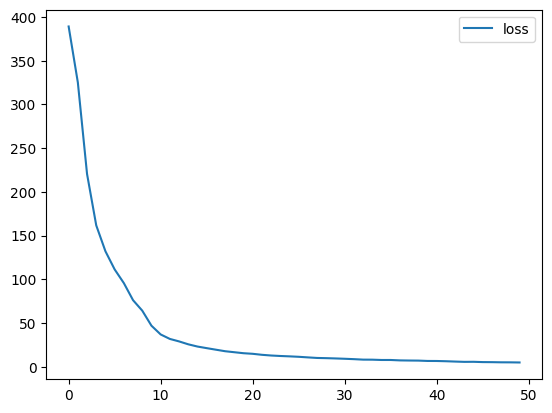

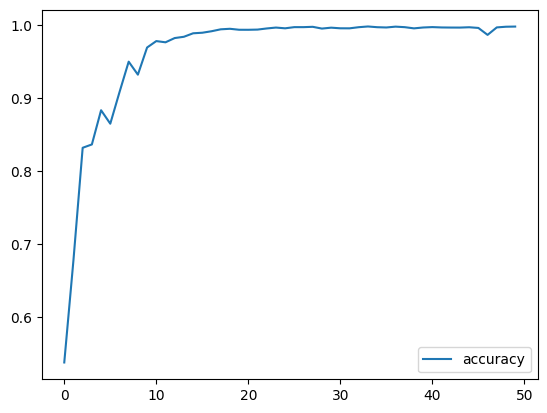

In [ ]:
main()

In [ ]:
main()

# OA PCT

## Classify

In [ ]:
class OAPCTransCls(nn.Module):
    def __init__(self,in_channel=3,out_channel=6,points_num=1024,task='classification'):
        super(OAPCTransCls,self).__init__()
        self.in_channel = in_channel
        self.out_channel = out_channel
        self.task = task

        self.embed = Embedding(in_channel)
        #self.sg = SampleGroup(in_channel)
        self.sa1 = OffSetAttention(128)
        self.sa2 = OffSetAttention(128)
        self.sa3 = OffSetAttention(128)
        self.sa4 = OffSetAttention(128)

        self.lbr1 = nn.Sequential(
                    nn.Conv1d(in_channels=512,out_channels=1024,kernel_size=1),
                    nn.BatchNorm1d(1024),
                    nn.ReLU()
                )

        #self.m = nn.MaxPool1d(1024,1)
        #self.avg = nn.MaxPool1d(1024,1)
        # for classification
        self.lbrd1 = nn.Sequential(
                    nn.Conv1d(in_channels=2048,out_channels=256,kernel_size=1),
                    nn.BatchNorm1d(256),
                    nn.ReLU(),
                    nn.Dropout()
                )

        self.lbrd2 = nn.Sequential(
                    nn.Conv1d(in_channels=256,out_channels=256,kernel_size=1),
                    nn.BatchNorm1d(256),
                    nn.ReLU(),
                    nn.Dropout()
                )

        self.l1 = nn.Conv1d(in_channels=256,out_channels=out_channel,kernel_size=1)

        # for segmentation
        self.lbrd3 = nn.Sequential(
                    nn.Conv1d(in_channels=3072,out_channels=256,kernel_size=1),
                    nn.BatchNorm1d(256),
                    nn.ReLU(),
                    nn.Dropout()
                    )

        self.lbr2 = nn.Sequential(
                    nn.Conv1d(in_channels=256,out_channels=256,kernel_size=1),
                    nn.BatchNorm1d(256),
                    nn.ReLU()
                )


    def forward(self,x):
        x0 = self.embed(x)
        x1 = self.sa1(x0)
        x2 = self.sa2(x1)
        x3 = self.sa3(x2)
        x4 = self.sa4(x3)
        x5 = torch.concatenate((x1,x2,x3,x4),1)
        x6 = self.lbr1(x5)#point feature

        #if self.task=='classification':
        x7 = torch.max(x6,-1)[0]
        x8 = torch.mean(x6,-1)
        x9 = torch.concatenate((x7,x8),1)
        x9 = x9.view(x9.shape[0],x9.shape[1],1)
        x10 = self.lbrd1(x9)
        x11 = self.lbrd2(x10)

        output = self.l1(x11)
        #print("output",output.shape)
        return output.view(output.shape[0],-1)


In [ ]:
losses = []
accuracy = []
def main():
    NUM_CLASSES = 10
    NUM_FEATURES = 6
    NUM_TRAIN_POINTS = 1024

    TASK = 'classification'
    model_save_path = os.path.join(os. getcwd(), 'drive/MyDrive/ROB498/model/best_classify_model10_NAIVE_normal.pt')
    learning_rate = 0.001
    #path = 'data/cls'
    Batch_size = 256
    num_epochs = 100
    if TASK=='classification':
      model = NaivePCTransCls(NUM_FEATURES,NUM_CLASSES,NUM_TRAIN_POINTS,TASK)
    else:
      model= NaivePCTransSeg(NUM_FEATURES,NUM_CLASSES,NUM_TRAIN_POINTS,TASK)
    device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
    #opt = optim.Adam(model.parameters(),learning_rate)
    opt = optim.SGD(model.parameters(),learning_rate,momentum=0.5)
    #path = os.path.join(os.getcwd(),'drive/MyDrive/ROB498/modelnet10_normal_resampled/')
    path = '/content/modelnet10_normal_resampled/'
    train_data = ModelNetDataLoader(root=path,npoint=NUM_TRAIN_POINTS, split='train', uniform=False, normal_channel=True)
    train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=Batch_size, shuffle=True)

    test_data = ModelNetDataLoader(root=path,npoint=NUM_TRAIN_POINTS, split='test', uniform=False, normal_channel=True)
    test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=Batch_size, shuffle=True)

    #train_dataloader = get_data_loader(path,batch_size,True)
    #test_dataloader = get_data_loader(path,batch_size,False)

    model = model.to(device)

    best_accuracy = -1
    for epoch in tqdm(range(num_epochs)):
        train_epoch_loss = train(train_dataloader,model,opt,epoch,device,TASK)
        test_accuracy = test(test_dataloader,model,epoch,device,TASK)
        #print(train_epoch_loss)
        losses.append(train_epoch_loss.item())
        accuracy.append(test_accuracy)
        print ("epoch: {}   train loss: {:.4f}   test accuracy: {:.4f}".format(epoch, train_epoch_loss, test_accuracy))
        if test_accuracy>best_accuracy:
           best_accuracy = test_accuracy
           torch.save(model.state_dict(),model_save_path)
    epoches = range(len(losses))
    plt.plot(epoches,losses,label='loss')
    plt.legend()
    plt.show()

    plt.plot(epoches,accuracy,label='accuracy')
    plt.legend()
    plt.show()

The size of train data is 3991
The size of test data is 908


  1%|          | 1/100 [00:44<1:12:37, 44.02s/it]

epoch: 0   train loss: 36.4300   test accuracy: 0.1101


  2%|▏         | 2/100 [00:47<33:07, 20.28s/it]  

epoch: 1   train loss: 28.6412   test accuracy: 0.3590


  3%|▎         | 3/100 [00:51<20:30, 12.69s/it]

epoch: 2   train loss: 24.7326   test accuracy: 0.6355


  4%|▍         | 4/100 [00:54<14:35,  9.12s/it]

epoch: 3   train loss: 22.2559   test accuracy: 0.6861


  5%|▌         | 5/100 [00:58<11:18,  7.14s/it]

epoch: 4   train loss: 20.3847   test accuracy: 0.7004


  6%|▌         | 6/100 [01:02<09:19,  5.96s/it]

epoch: 5   train loss: 18.8514   test accuracy: 0.7093


  7%|▋         | 7/100 [01:05<08:03,  5.20s/it]

epoch: 6   train loss: 17.7094   test accuracy: 0.7225


  8%|▊         | 8/100 [01:09<07:13,  4.71s/it]

epoch: 7   train loss: 16.8369   test accuracy: 0.7269


  9%|▉         | 9/100 [01:13<06:38,  4.38s/it]

epoch: 8   train loss: 15.9696   test accuracy: 0.7357


 10%|█         | 10/100 [01:16<06:13,  4.15s/it]

epoch: 9   train loss: 15.1921   test accuracy: 0.7434


 11%|█         | 11/100 [01:20<05:55,  4.00s/it]

epoch: 10   train loss: 14.5445   test accuracy: 0.7544


 12%|█▏        | 12/100 [01:24<05:41,  3.88s/it]

epoch: 11   train loss: 14.0389   test accuracy: 0.7544


 13%|█▎        | 13/100 [01:27<05:31,  3.81s/it]

epoch: 12   train loss: 13.4475   test accuracy: 0.7632


 14%|█▍        | 14/100 [01:31<05:23,  3.76s/it]

epoch: 13   train loss: 13.0327   test accuracy: 0.7709


 15%|█▌        | 15/100 [01:35<05:16,  3.73s/it]

epoch: 14   train loss: 12.6228   test accuracy: 0.7797


 16%|█▌        | 16/100 [01:38<05:11,  3.71s/it]

epoch: 15   train loss: 12.2714   test accuracy: 0.7874


 17%|█▋        | 17/100 [01:42<05:06,  3.69s/it]

epoch: 16   train loss: 11.8204   test accuracy: 0.7885


 18%|█▊        | 18/100 [01:46<05:01,  3.68s/it]

epoch: 17   train loss: 11.5653   test accuracy: 0.7952


 19%|█▉        | 19/100 [01:49<04:57,  3.67s/it]

epoch: 18   train loss: 11.1703   test accuracy: 0.7963


 20%|██        | 20/100 [01:53<04:53,  3.66s/it]

epoch: 19   train loss: 11.0332   test accuracy: 0.8040


 21%|██        | 21/100 [01:56<04:48,  3.66s/it]

epoch: 20   train loss: 10.5493   test accuracy: 0.8128


 22%|██▏       | 22/100 [02:00<04:44,  3.65s/it]

epoch: 21   train loss: 10.2889   test accuracy: 0.8139


 23%|██▎       | 23/100 [02:04<04:41,  3.65s/it]

epoch: 22   train loss: 10.1395   test accuracy: 0.8161


 24%|██▍       | 24/100 [02:07<04:37,  3.65s/it]

epoch: 23   train loss: 9.8624   test accuracy: 0.8183


 25%|██▌       | 25/100 [02:11<04:33,  3.65s/it]

epoch: 24   train loss: 9.6372   test accuracy: 0.8227


 26%|██▌       | 26/100 [02:15<04:30,  3.65s/it]

epoch: 25   train loss: 9.6075   test accuracy: 0.8238


 27%|██▋       | 27/100 [02:18<04:26,  3.65s/it]

epoch: 26   train loss: 9.2374   test accuracy: 0.8249


 28%|██▊       | 28/100 [02:22<04:22,  3.65s/it]

epoch: 27   train loss: 8.9365   test accuracy: 0.8326


 29%|██▉       | 29/100 [02:26<04:18,  3.64s/it]

epoch: 28   train loss: 8.7275   test accuracy: 0.8315


 30%|███       | 30/100 [02:29<04:13,  3.63s/it]

epoch: 29   train loss: 8.6582   test accuracy: 0.8315


 31%|███       | 31/100 [02:33<04:10,  3.63s/it]

epoch: 30   train loss: 8.4625   test accuracy: 0.8359


 32%|███▏      | 32/100 [02:37<04:07,  3.64s/it]

epoch: 31   train loss: 8.3051   test accuracy: 0.8403


 33%|███▎      | 33/100 [02:40<04:04,  3.64s/it]

epoch: 32   train loss: 8.1017   test accuracy: 0.8469


 34%|███▍      | 34/100 [02:44<03:59,  3.63s/it]

epoch: 33   train loss: 7.9528   test accuracy: 0.8436


 35%|███▌      | 35/100 [02:47<03:56,  3.64s/it]

epoch: 34   train loss: 7.8008   test accuracy: 0.8557


 36%|███▌      | 36/100 [02:51<03:52,  3.63s/it]

epoch: 35   train loss: 7.5041   test accuracy: 0.8524


 37%|███▋      | 37/100 [02:55<03:49,  3.64s/it]

epoch: 36   train loss: 7.5027   test accuracy: 0.8590


 38%|███▊      | 38/100 [02:58<03:44,  3.63s/it]

epoch: 37   train loss: 7.3834   test accuracy: 0.8590


 39%|███▉      | 39/100 [03:02<03:40,  3.62s/it]

epoch: 38   train loss: 7.2829   test accuracy: 0.8557


 40%|████      | 40/100 [03:06<03:37,  3.63s/it]

epoch: 39   train loss: 7.1709   test accuracy: 0.8623


 41%|████      | 41/100 [03:09<03:34,  3.64s/it]

epoch: 40   train loss: 7.1072   test accuracy: 0.8656


 42%|████▏     | 42/100 [03:13<03:30,  3.63s/it]

epoch: 41   train loss: 6.9656   test accuracy: 0.8645


 43%|████▎     | 43/100 [03:16<03:26,  3.62s/it]

epoch: 42   train loss: 6.7606   test accuracy: 0.8656


 44%|████▍     | 44/100 [03:20<03:23,  3.63s/it]

epoch: 43   train loss: 6.6514   test accuracy: 0.8711


 45%|████▌     | 45/100 [03:24<03:19,  3.64s/it]

epoch: 44   train loss: 6.5387   test accuracy: 0.8722


 46%|████▌     | 46/100 [03:27<03:16,  3.64s/it]

epoch: 45   train loss: 6.5025   test accuracy: 0.8767


 47%|████▋     | 47/100 [03:31<03:12,  3.64s/it]

epoch: 46   train loss: 6.3392   test accuracy: 0.8899


 48%|████▊     | 48/100 [03:35<03:08,  3.63s/it]

epoch: 47   train loss: 6.2388   test accuracy: 0.8866


 49%|████▉     | 49/100 [03:38<03:04,  3.62s/it]

epoch: 48   train loss: 6.1644   test accuracy: 0.8899


 50%|█████     | 50/100 [03:42<03:01,  3.63s/it]

epoch: 49   train loss: 5.9337   test accuracy: 0.8921


 51%|█████     | 51/100 [03:46<02:58,  3.64s/it]

epoch: 50   train loss: 6.1303   test accuracy: 0.8932


 52%|█████▏    | 52/100 [03:49<02:54,  3.64s/it]

epoch: 51   train loss: 5.9446   test accuracy: 0.8943


 53%|█████▎    | 53/100 [03:53<02:51,  3.64s/it]

epoch: 52   train loss: 5.9032   test accuracy: 0.8998


 54%|█████▍    | 54/100 [03:56<02:47,  3.64s/it]

epoch: 53   train loss: 5.6913   test accuracy: 0.9031


 55%|█████▌    | 55/100 [04:00<02:43,  3.63s/it]

epoch: 54   train loss: 5.7310   test accuracy: 0.9031


 56%|█████▌    | 56/100 [04:04<02:39,  3.63s/it]

epoch: 55   train loss: 5.6203   test accuracy: 0.8987


 57%|█████▋    | 57/100 [04:07<02:35,  3.62s/it]

epoch: 56   train loss: 5.5686   test accuracy: 0.9020


 58%|█████▊    | 58/100 [04:11<02:31,  3.62s/it]

epoch: 57   train loss: 5.5046   test accuracy: 0.9020


 59%|█████▉    | 59/100 [04:15<02:28,  3.63s/it]

epoch: 58   train loss: 5.4373   test accuracy: 0.9097


 60%|██████    | 60/100 [04:18<02:24,  3.62s/it]

epoch: 59   train loss: 5.2220   test accuracy: 0.9086


 61%|██████    | 61/100 [04:22<02:21,  3.63s/it]

epoch: 60   train loss: 5.1707   test accuracy: 0.9141


 62%|██████▏   | 62/100 [04:25<02:17,  3.62s/it]

epoch: 61   train loss: 5.2229   test accuracy: 0.9097


 63%|██████▎   | 63/100 [04:29<02:14,  3.63s/it]

epoch: 62   train loss: 5.0137   test accuracy: 0.9152


 64%|██████▍   | 64/100 [04:33<02:10,  3.62s/it]

epoch: 63   train loss: 4.8964   test accuracy: 0.9130


 65%|██████▌   | 65/100 [04:36<02:06,  3.62s/it]

epoch: 64   train loss: 4.9842   test accuracy: 0.9152


 66%|██████▌   | 66/100 [04:40<02:03,  3.63s/it]

epoch: 65   train loss: 4.9830   test accuracy: 0.9174


 67%|██████▋   | 67/100 [04:44<01:59,  3.62s/it]

epoch: 66   train loss: 4.7692   test accuracy: 0.9163


 68%|██████▊   | 68/100 [04:47<01:56,  3.63s/it]

epoch: 67   train loss: 4.7279   test accuracy: 0.9196


 69%|██████▉   | 69/100 [04:51<01:52,  3.62s/it]

epoch: 68   train loss: 4.6779   test accuracy: 0.9196


 70%|███████   | 70/100 [04:54<01:48,  3.62s/it]

epoch: 69   train loss: 4.6422   test accuracy: 0.9174


 71%|███████   | 71/100 [04:58<01:44,  3.62s/it]

epoch: 70   train loss: 4.5901   test accuracy: 0.9185


 72%|███████▏  | 72/100 [05:02<01:41,  3.63s/it]

epoch: 71   train loss: 4.6219   test accuracy: 0.9218


 73%|███████▎  | 73/100 [05:05<01:38,  3.63s/it]

epoch: 72   train loss: 4.4664   test accuracy: 0.9229


 74%|███████▍  | 74/100 [05:09<01:34,  3.62s/it]

epoch: 73   train loss: 4.4033   test accuracy: 0.9229


 75%|███████▌  | 75/100 [05:13<01:30,  3.62s/it]

epoch: 74   train loss: 4.4341   test accuracy: 0.9196


 76%|███████▌  | 76/100 [05:16<01:27,  3.63s/it]

epoch: 75   train loss: 4.3292   test accuracy: 0.9251


 77%|███████▋  | 77/100 [05:20<01:23,  3.62s/it]

epoch: 76   train loss: 4.2585   test accuracy: 0.9251


 78%|███████▊  | 78/100 [05:23<01:19,  3.63s/it]

epoch: 77   train loss: 4.2372   test accuracy: 0.9262


 79%|███████▉  | 79/100 [05:27<01:16,  3.62s/it]

epoch: 78   train loss: 4.2086   test accuracy: 0.9262


 80%|████████  | 80/100 [05:31<01:12,  3.62s/it]

epoch: 79   train loss: 4.1705   test accuracy: 0.9262


 81%|████████  | 81/100 [05:34<01:08,  3.63s/it]

epoch: 80   train loss: 4.0328   test accuracy: 0.9273


 82%|████████▏ | 82/100 [05:38<01:05,  3.62s/it]

epoch: 81   train loss: 4.0231   test accuracy: 0.9273


 83%|████████▎ | 83/100 [05:41<01:01,  3.62s/it]

epoch: 82   train loss: 3.9933   test accuracy: 0.9273


 84%|████████▍ | 84/100 [05:45<00:58,  3.63s/it]

epoch: 83   train loss: 3.8702   test accuracy: 0.9284


 85%|████████▌ | 85/100 [05:49<00:54,  3.62s/it]

epoch: 84   train loss: 3.8731   test accuracy: 0.9273


 86%|████████▌ | 86/100 [05:52<00:50,  3.62s/it]

epoch: 85   train loss: 3.8453   test accuracy: 0.9273


 87%|████████▋ | 87/100 [05:56<00:46,  3.61s/it]

epoch: 86   train loss: 3.8328   test accuracy: 0.9284


 88%|████████▊ | 88/100 [06:00<00:43,  3.61s/it]

epoch: 87   train loss: 3.8204   test accuracy: 0.9273


 89%|████████▉ | 89/100 [06:03<00:39,  3.61s/it]

epoch: 88   train loss: 3.8336   test accuracy: 0.9273


 90%|█████████ | 90/100 [06:07<00:36,  3.62s/it]

epoch: 89   train loss: 3.6778   test accuracy: 0.9295


 91%|█████████ | 91/100 [06:10<00:32,  3.62s/it]

epoch: 90   train loss: 3.6869   test accuracy: 0.9273


 92%|█████████▏| 92/100 [06:14<00:28,  3.62s/it]

epoch: 91   train loss: 3.5690   test accuracy: 0.9262


 93%|█████████▎| 93/100 [06:18<00:25,  3.61s/it]

epoch: 92   train loss: 3.7237   test accuracy: 0.9284


 94%|█████████▍| 94/100 [06:21<00:21,  3.61s/it]

epoch: 93   train loss: 3.5358   test accuracy: 0.9273


 95%|█████████▌| 95/100 [06:25<00:18,  3.61s/it]

epoch: 94   train loss: 3.5382   test accuracy: 0.9273


 96%|█████████▌| 96/100 [06:28<00:14,  3.61s/it]

epoch: 95   train loss: 3.4789   test accuracy: 0.9262


 97%|█████████▋| 97/100 [06:32<00:10,  3.61s/it]

epoch: 96   train loss: 3.5176   test accuracy: 0.9284


 98%|█████████▊| 98/100 [06:36<00:07,  3.61s/it]

epoch: 97   train loss: 3.3564   test accuracy: 0.9284


 99%|█████████▉| 99/100 [06:39<00:03,  3.61s/it]

epoch: 98   train loss: 3.4125   test accuracy: 0.9284


100%|██████████| 100/100 [06:43<00:00,  4.03s/it]

epoch: 99   train loss: 3.4519   test accuracy: 0.9273


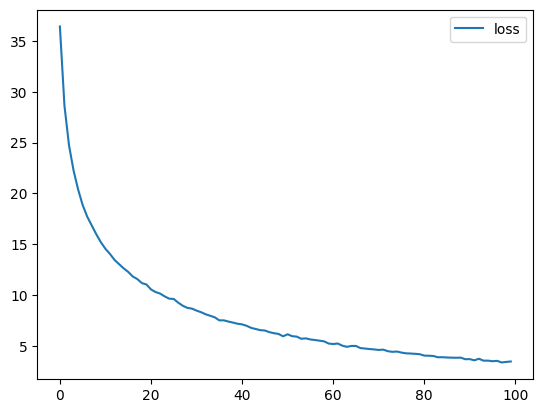

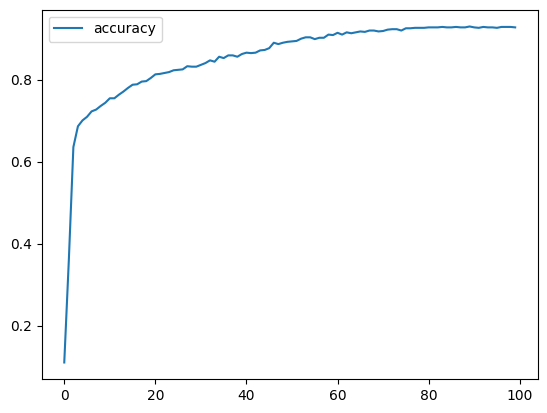

In [ ]:
main()

## Segmentation

In [ ]:
class OAPCTransSeg(nn.Module):
    def __init__(self,in_channel=3,out_channel=6,points_num=1024,task='classification',version='naive'):
        super(OAPCTransSeg,self).__init__()
        self.in_channel = in_channel
        self.out_channel = out_channel
        self.task = task

        self.embed = Embedding(in_channel)
        #self.sg = SampleGroup(in_channel)
        self.sa1 = OffSetAttention(128)#SelfAttention(128)
        self.sa2 = OffSetAttention(128)#SelfAttention(128)
        self.sa3 = OffSetAttention(128)#SelfAttention(128)
        self.sa4 = OffSetAttention(128)#SelfAttention(128)

        self.lbr1 = nn.Sequential(
                    nn.Conv1d(in_channels=512,out_channels=1024,kernel_size=1),
                    nn.BatchNorm1d(1024),
                    nn.ReLU()
                )

        #self.m = nn.MaxPool1d(1024,1)
        #self.avg = nn.MaxPool1d(1024,1)
        # for classification
        self.lbrd1 = nn.Sequential(
                    nn.Conv1d(in_channels=2048,out_channels=256,kernel_size=1),
                    nn.BatchNorm1d(256),
                    nn.ReLU(),
                    nn.Dropout()
                )

        self.lbrd2 = nn.Sequential(
                    nn.Conv1d(in_channels=256,out_channels=256,kernel_size=1),
                    nn.BatchNorm1d(256),
                    nn.ReLU(),
                    nn.Dropout()
                )

        self.l1 = nn.Conv1d(in_channels=256,out_channels=out_channel,kernel_size=1)

        # for segmentation
        self.lbrd3 = nn.Sequential(
                    nn.Conv1d(in_channels=3072,out_channels=256,kernel_size=1),
                    nn.BatchNorm1d(256),
                    nn.ReLU(),
                    nn.Dropout()
                    )

        self.lbrd4 = nn.Sequential(
                    nn.Conv1d(in_channels=3136,out_channels=512,kernel_size=1),
                    nn.BatchNorm1d(512),
                    nn.ReLU(),
                    nn.Dropout()
                )
        self.lbr2 = nn.Sequential(
                    nn.Conv1d(in_channels=512,out_channels=256,kernel_size=1),
                    nn.BatchNorm1d(256),
                    nn.ReLU()
                )
        self.Conv1 = nn.Conv1d(256,self.out_channel,1)

        self.label_lbr = nn.Sequential(
                    nn.Conv1d(in_channels=1,out_channels=64,kernel_size=1),
                    nn.BatchNorm1d(64),
                    nn.ReLU(),
                    )


    def forward(self,x,labels):
          B,C,N = x.size()
          x0 = self.embed(x)
          x1 = self.sa1(x0)
          x2 = self.sa2(x1)
          x3 = self.sa3(x2)
          x4 = self.sa4(x3)
          x5 = torch.concatenate((x1,x2,x3,x4),1)
          x6 = self.lbr1(x5)#point feature
          #print(x6.shape)

          x_max = torch.max(x6,dim=-1)[0]
          x_mean = torch.mean(x6,dim=-1)
          x_max_features = x_max.unsqueeze(-1).repeat(1,1,N)
          x_mean_features = x_mean.unsqueeze(-1).repeat(1,1,N)
          labels_features = self.label_lbr(labels.view(B,1,N))
          x7 = torch.cat([x6,x_max_features,x_mean_features,labels_features],1)
          #print(x7.shape)
          x8 = self.lbrd4(x7)
          x9 = self.lbr2(x8)
          x10 = self.Conv1(x9)
          return x10


In [ ]:
losses = []
accuracy = []
def main():
    NUM_CLASSES = 6
    NUM_FEATURES = 3
    NUM_TRAIN_POINTS = 1024

    TASK = 'segmentation'
    model_save_path = os.path.join(os. getcwd(), 'drive/MyDrive/ROB498/model/best_segmentation_model10_OA_normal.pt')
    learning_rate = 0.001
    Batch_size = 32
    num_epochs = 50
    if TASK=='classification':
      model = OAPCTransCls(NUM_FEATURES,NUM_CLASSES,NUM_TRAIN_POINTS,TASK)
    else:
      model= OAPCTransSeg(NUM_FEATURES,NUM_CLASSES,NUM_TRAIN_POINTS,TASK)
    device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
    #opt = optim.Adam(model.parameters(),learning_rate)
    opt = optim.SGD(model.parameters(),learning_rate,momentum=0.5)
    #path = os.path.join(os.getcwd(),'drive/MyDrive/ROB498/modelnet10_normal_resampled/')
    path = '/content/data/seg/'
    train_dataloader = get_data_loader(path,Batch_size, True)
    test_dataloader = get_data_loader(path,Batch_size, False)

    model = model.to(device)

    best_accuracy = -1
    for epoch in tqdm(range(num_epochs)):
        train_epoch_loss = train(train_dataloader,model,opt,epoch,device,TASK)
        test_accuracy = test(test_dataloader,model,epoch,device,TASK)
        #print(train_epoch_loss)
        losses.append(train_epoch_loss.item())
        accuracy.append(test_accuracy)
        print ("epoch: {}   train loss: {:.4f}   test accuracy: {:.4f}".format(epoch, train_epoch_loss, test_accuracy))
        if test_accuracy>best_accuracy:
           best_accuracy = test_accuracy
           torch.save(model.state_dict(),model_save_path)
    epoches = range(len(losses))
    plt.plot(epoches,losses,label='loss')
    plt.legend()
    plt.show()

    plt.plot(epoches,accuracy,label='accuracy')
    plt.legend()
    plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]

epoch: 0   train loss: 124.2784   test accuracy: 0.8788


  4%|▍         | 2/50 [00:18<06:52,  8.60s/it]

epoch: 1   train loss: 62.7476   test accuracy: 0.9195


  6%|▌         | 3/50 [00:24<05:44,  7.32s/it]

epoch: 2   train loss: 44.2246   test accuracy: 0.9461


  8%|▊         | 4/50 [00:29<05:09,  6.72s/it]

epoch: 3   train loss: 33.9228   test accuracy: 0.9612


 10%|█         | 5/50 [00:35<04:48,  6.40s/it]

epoch: 4   train loss: 27.2253   test accuracy: 0.9712


 12%|█▏        | 6/50 [00:41<04:32,  6.20s/it]

epoch: 5   train loss: 22.8416   test accuracy: 0.9774


 14%|█▍        | 7/50 [00:47<04:21,  6.08s/it]

epoch: 6   train loss: 19.7656   test accuracy: 0.9815


 16%|█▌        | 8/50 [00:53<04:11,  5.99s/it]

epoch: 7   train loss: 17.3627   test accuracy: 0.9837


 18%|█▊        | 9/50 [00:59<04:03,  5.94s/it]

epoch: 8   train loss: 15.6750   test accuracy: 0.9859


 20%|██        | 10/50 [01:04<03:56,  5.90s/it]

epoch: 9   train loss: 14.2267   test accuracy: 0.9878


 22%|██▏       | 11/50 [01:10<03:49,  5.88s/it]

epoch: 10   train loss: 13.0145   test accuracy: 0.9888


 24%|██▍       | 12/50 [01:16<03:42,  5.87s/it]

epoch: 11   train loss: 11.9736   test accuracy: 0.9902


 26%|██▌       | 13/50 [01:22<03:36,  5.86s/it]

epoch: 12   train loss: 11.1319   test accuracy: 0.9911


 28%|██▊       | 14/50 [01:28<03:30,  5.85s/it]

epoch: 13   train loss: 10.3810   test accuracy: 0.9920


 30%|███       | 15/50 [01:34<03:24,  5.85s/it]

epoch: 14   train loss: 9.7567   test accuracy: 0.9924


 32%|███▏      | 16/50 [01:39<03:18,  5.84s/it]

epoch: 15   train loss: 9.2676   test accuracy: 0.9931


 34%|███▍      | 17/50 [01:45<03:12,  5.84s/it]

epoch: 16   train loss: 8.7620   test accuracy: 0.9936


 36%|███▌      | 18/50 [01:51<03:06,  5.83s/it]

epoch: 17   train loss: 8.2225   test accuracy: 0.9939


 38%|███▊      | 19/50 [01:57<03:01,  5.84s/it]

epoch: 18   train loss: 7.8039   test accuracy: 0.9942


 40%|████      | 20/50 [02:03<02:55,  5.84s/it]

epoch: 19   train loss: 7.4829   test accuracy: 0.9947


 42%|████▏     | 21/50 [02:09<02:49,  5.85s/it]

epoch: 20   train loss: 7.1730   test accuracy: 0.9950


 44%|████▍     | 22/50 [02:14<02:43,  5.85s/it]

epoch: 21   train loss: 6.8718   test accuracy: 0.9951


 46%|████▌     | 23/50 [02:20<02:37,  5.84s/it]

epoch: 22   train loss: 6.5958   test accuracy: 0.9954


 48%|████▊     | 24/50 [02:26<02:31,  5.84s/it]

epoch: 23   train loss: 6.3179   test accuracy: 0.9956


 50%|█████     | 25/50 [02:32<02:25,  5.84s/it]

epoch: 24   train loss: 6.0921   test accuracy: 0.9957


 52%|█████▏    | 26/50 [02:38<02:20,  5.85s/it]

epoch: 25   train loss: 5.8556   test accuracy: 0.9959


 54%|█████▍    | 27/50 [02:44<02:14,  5.85s/it]

epoch: 26   train loss: 5.9720   test accuracy: 0.9960


 56%|█████▌    | 28/50 [02:50<02:08,  5.85s/it]

epoch: 27   train loss: 5.4515   test accuracy: 0.9961


 58%|█████▊    | 29/50 [02:55<02:02,  5.85s/it]

epoch: 28   train loss: 5.3130   test accuracy: 0.9962


 60%|██████    | 30/50 [03:01<01:56,  5.84s/it]

epoch: 29   train loss: 5.1734   test accuracy: 0.9963


 62%|██████▏   | 31/50 [03:07<01:51,  5.84s/it]

epoch: 30   train loss: 4.9381   test accuracy: 0.9965


 64%|██████▍   | 32/50 [03:13<01:44,  5.83s/it]

epoch: 31   train loss: 4.8641   test accuracy: 0.9965


 66%|██████▌   | 33/50 [03:19<01:39,  5.83s/it]

epoch: 32   train loss: 4.7143   test accuracy: 0.9966


 68%|██████▊   | 34/50 [03:25<01:33,  5.84s/it]

epoch: 33   train loss: 4.5621   test accuracy: 0.9967


 70%|███████   | 35/50 [03:30<01:27,  5.84s/it]

epoch: 34   train loss: 4.4439   test accuracy: 0.9968


 72%|███████▏  | 36/50 [03:36<01:21,  5.85s/it]

epoch: 35   train loss: 4.2361   test accuracy: 0.9968


 74%|███████▍  | 37/50 [03:42<01:15,  5.84s/it]

epoch: 36   train loss: 4.1955   test accuracy: 0.9969


 76%|███████▌  | 38/50 [03:48<01:10,  5.84s/it]

epoch: 37   train loss: 4.0562   test accuracy: 0.9970


 78%|███████▊  | 39/50 [03:54<01:04,  5.84s/it]

epoch: 38   train loss: 3.9464   test accuracy: 0.9970


 80%|████████  | 40/50 [04:00<00:58,  5.83s/it]

epoch: 39   train loss: 3.8442   test accuracy: 0.9970


 82%|████████▏ | 41/50 [04:05<00:52,  5.84s/it]

epoch: 40   train loss: 3.7881   test accuracy: 0.9972


 84%|████████▍ | 42/50 [04:11<00:46,  5.84s/it]

epoch: 41   train loss: 3.6494   test accuracy: 0.9972


 86%|████████▌ | 43/50 [04:17<00:40,  5.85s/it]

epoch: 42   train loss: 3.6073   test accuracy: 0.9973


 88%|████████▊ | 44/50 [04:23<00:35,  5.84s/it]

epoch: 43   train loss: 3.5194   test accuracy: 0.9973


 90%|█████████ | 45/50 [04:29<00:29,  5.85s/it]

epoch: 44   train loss: 3.3886   test accuracy: 0.9974


 92%|█████████▏| 46/50 [04:35<00:23,  5.82s/it]

epoch: 45   train loss: 3.3163   test accuracy: 0.9974


 94%|█████████▍| 47/50 [04:40<00:17,  5.83s/it]

epoch: 46   train loss: 3.3834   test accuracy: 0.9974


 96%|█████████▌| 48/50 [04:46<00:11,  5.83s/it]

epoch: 47   train loss: 3.2194   test accuracy: 0.9975


 98%|█████████▊| 49/50 [04:52<00:05,  5.82s/it]

epoch: 48   train loss: 3.1048   test accuracy: 0.9975


100%|██████████| 50/50 [04:58<00:00,  5.97s/it]

epoch: 49   train loss: 3.0519   test accuracy: 0.9976


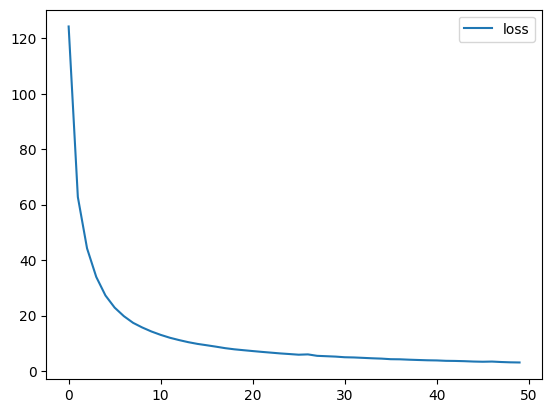

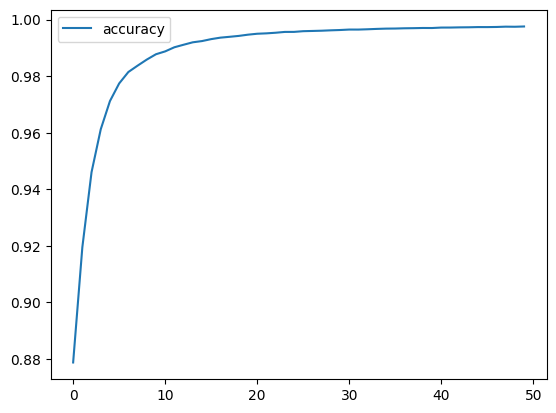

In [ ]:
main()

# Full PCT

## Classify

In [ ]:
class FullPCTransCls(nn.Module):
    def __init__(self,in_channel=3,out_channel=6,points_num=1024,task='classification',version='naive'):
        super(FullPCTransCls,self).__init__()
        self.in_channel = in_channel
        self.out_channel = out_channel
        self.task = task

        self.embed = NeighborEmbedding(6)
        #self.sg = SampleGroup(in_channel)
        self.sa1 = OffSetAttention(256)
        self.sa2 = OffSetAttention(256)
        self.sa3 = OffSetAttention(256)
        self.sa4 = OffSetAttention(256)

        self.lbr1 = nn.Sequential(
                    nn.Conv1d(in_channels=1280,out_channels=1024,kernel_size=1),
                    nn.BatchNorm1d(1024),
                    nn.ReLU()
                )

        #self.m = nn.MaxPool1d(1024,1)
        #self.avg = nn.MaxPool1d(1024,1)
        # for classification
        self.lbrd1 = nn.Sequential(
                    nn.Conv1d(in_channels=2048,out_channels=256,kernel_size=1),
                    nn.BatchNorm1d(256),
                    nn.ReLU(),
                    nn.Dropout()
                )

        self.lbrd2 = nn.Sequential(
                    nn.Conv1d(in_channels=256,out_channels=256,kernel_size=1),
                    nn.BatchNorm1d(256),
                    nn.ReLU(),
                    nn.Dropout()
                )

        self.l1 = nn.Conv1d(in_channels=256,out_channels=out_channel,kernel_size=1)

        # for segmentation
        self.lbrd3 = nn.Sequential(
                    nn.Conv1d(in_channels=3072,out_channels=256,kernel_size=1),
                    nn.BatchNorm1d(256),
                    nn.ReLU(),
                    nn.Dropout()
                    )

        self.lbr2 = nn.Sequential(
                    nn.Conv1d(in_channels=256,out_channels=256,kernel_size=1),
                    nn.BatchNorm1d(256),
                    nn.ReLU()
                )


    def forward(self,x):
        x0 = self.embed(x)# batch,256,256
        x1 = self.sa1(x0)#256
        x2 = self.sa2(x1)
        x3 = self.sa3(x2)
        x4 = self.sa4(x3)#256

        x5 = torch.concatenate((x0,x1,x2,x3,x4),1)#1280
        x6 = self.lbr1(x5)#point feature

        #if self.task=='classification':
        x7 = torch.max(x6,-1)[0]
        x8 = torch.mean(x6,-1)
        x9 = torch.concatenate((x7,x8),1)
        x9 = x9.view(x9.shape[0],x9.shape[1],1)
        x10 = self.lbrd1(x9)
        x11 = self.lbrd2(x10)

        output = self.l1(x11)
        #print("output",output.shape)
        return output.view(output.shape[0],-1)


In [ ]:
losses = []
accuracy = []
def main1():
    NUM_CLASSES = 10
    NUM_FEATURES = 6
    NUM_TRAIN_POINTS = 1024
    TASK = 'classification'
    VERSION = 'FULL'
    model_save_path = os.path.join(os. getcwd(), 'drive/MyDrive/ROB498/model/best_classify_model10_FULL_normal.pt')
    learning_rate = 0.001
    #path = 'data/cls'
    Batch_size = 256
    num_epochs = 100
    if TASK=='classification':
      model = FullPCTransCls(NUM_FEATURES,NUM_CLASSES,NUM_TRAIN_POINTS,TASK)
    else:
      model= FullPCTransSeg(NUM_FEATURES,NUM_CLASSES,NUM_TRAIN_POINTS,TASK)
    device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
    #opt = optim.Adam(model.parameters(),learning_rate)
    opt = optim.SGD(model.parameters(),learning_rate,momentum=0.5)
    #path = os.path.join(os.getcwd(),'drive/MyDrive/ROB498/modelnet10_normal_resampled/')
    path = '/content/modelnet10_normal_resampled/'
    train_data = ModelNetDataLoader(root=path,npoint=NUM_TRAIN_POINTS, split='train', uniform=False, normal_channel=True)
    train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=Batch_size, shuffle=True)

    test_data = ModelNetDataLoader(root=path,npoint=NUM_TRAIN_POINTS, split='test', uniform=False, normal_channel=True)
    test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=Batch_size, shuffle=True)

    #train_dataloader = get_data_loader(path,batch_size,True)
    #test_dataloader = get_data_loader(path,batch_size,False)

    model = model.to(device)

    best_accuracy = -1
    for epoch in tqdm(range(num_epochs)):
        train_epoch_loss = train(train_dataloader,model,opt,epoch,device,TASK)
        test_accuracy = test(test_dataloader,model,epoch,device,TASK)
        #print(train_epoch_loss)
        losses.append(train_epoch_loss.item())
        accuracy.append(test_accuracy)
        print ("epoch: {}   train loss: {:.4f}   test accuracy: {:.4f}".format(epoch, train_epoch_loss, test_accuracy))
        if test_accuracy>best_accuracy:
           best_accuracy = test_accuracy
           torch.save(model.state_dict(),model_save_path)
    epoches = range(len(losses))
    plt.plot(epoches,losses,label='loss')
    plt.legend()
    plt.show()

    plt.plot(epoches,accuracy,label='accuracy')
    plt.legend()
    plt.show()

The size of train data is 3991
The size of test data is 908


  0%|          | 0/100 [00:00<?, ?it/s]

epoch: 0   train loss: 35.1131   test accuracy: 0.1101


  2%|▏         | 2/100 [00:58<42:09, 25.81s/it]  

epoch: 1   train loss: 29.5163   test accuracy: 0.1101


  3%|▎         | 3/100 [01:07<29:28, 18.24s/it]

epoch: 2   train loss: 26.2387   test accuracy: 0.5066


  4%|▍         | 4/100 [01:17<23:27, 14.66s/it]

epoch: 3   train loss: 23.7563   test accuracy: 0.6729


  5%|▌         | 5/100 [01:26<20:05, 12.69s/it]

epoch: 4   train loss: 22.0509   test accuracy: 0.6784


  6%|▌         | 6/100 [01:35<18:00, 11.49s/it]

epoch: 5   train loss: 20.3965   test accuracy: 0.7048


  7%|▋         | 7/100 [01:44<16:38, 10.74s/it]

epoch: 6   train loss: 19.3380   test accuracy: 0.7081


  8%|▊         | 8/100 [01:53<15:43, 10.25s/it]

epoch: 7   train loss: 18.2133   test accuracy: 0.7280


  9%|▉         | 9/100 [02:03<15:04,  9.94s/it]

epoch: 8   train loss: 17.2131   test accuracy: 0.7324


 10%|█         | 10/100 [02:12<14:32,  9.69s/it]

epoch: 9   train loss: 16.5132   test accuracy: 0.7313


 11%|█         | 11/100 [02:21<14:09,  9.55s/it]

epoch: 10   train loss: 15.7090   test accuracy: 0.7423


 12%|█▏        | 12/100 [02:30<13:53,  9.47s/it]

epoch: 11   train loss: 15.2117   test accuracy: 0.7478


 13%|█▎        | 13/100 [02:40<13:38,  9.40s/it]

epoch: 12   train loss: 14.6145   test accuracy: 0.7544


 14%|█▍        | 14/100 [02:49<13:23,  9.35s/it]

epoch: 13   train loss: 14.0158   test accuracy: 0.7599


 15%|█▌        | 15/100 [02:58<13:12,  9.32s/it]

epoch: 14   train loss: 13.7545   test accuracy: 0.7698


 16%|█▌        | 16/100 [03:07<12:58,  9.27s/it]

epoch: 15   train loss: 13.1474   test accuracy: 0.7654


 17%|█▋        | 17/100 [03:16<12:48,  9.25s/it]

epoch: 16   train loss: 12.7013   test accuracy: 0.7841


 18%|█▊        | 18/100 [03:26<12:37,  9.24s/it]

epoch: 17   train loss: 12.2822   test accuracy: 0.7907


 19%|█▉        | 19/100 [03:35<12:28,  9.24s/it]

epoch: 18   train loss: 12.0833   test accuracy: 0.8051


 20%|██        | 20/100 [03:44<12:17,  9.22s/it]

epoch: 19   train loss: 11.6227   test accuracy: 0.7985


 21%|██        | 21/100 [03:53<12:09,  9.23s/it]

epoch: 20   train loss: 11.4280   test accuracy: 0.8128


 22%|██▏       | 22/100 [04:02<11:58,  9.21s/it]

epoch: 21   train loss: 11.0936   test accuracy: 0.8073


 23%|██▎       | 23/100 [04:12<11:48,  9.20s/it]

epoch: 22   train loss: 10.8409   test accuracy: 0.8095


 24%|██▍       | 24/100 [04:21<11:39,  9.20s/it]

epoch: 23   train loss: 10.4830   test accuracy: 0.8183


 25%|██▌       | 25/100 [04:30<11:30,  9.21s/it]

epoch: 24   train loss: 10.2351   test accuracy: 0.8227


 26%|██▌       | 26/100 [04:39<11:21,  9.20s/it]

epoch: 25   train loss: 9.9866   test accuracy: 0.8282


 27%|██▋       | 27/100 [04:48<11:11,  9.20s/it]

epoch: 26   train loss: 9.7433   test accuracy: 0.8315


 28%|██▊       | 28/100 [04:58<11:02,  9.20s/it]

epoch: 27   train loss: 9.6547   test accuracy: 0.8337


 29%|██▉       | 29/100 [05:07<10:52,  9.19s/it]

epoch: 28   train loss: 9.5080   test accuracy: 0.8392


 30%|███       | 30/100 [05:16<10:43,  9.20s/it]

epoch: 29   train loss: 9.3438   test accuracy: 0.8436


 31%|███       | 31/100 [05:25<10:33,  9.18s/it]

epoch: 30   train loss: 8.9971   test accuracy: 0.8403


 32%|███▏      | 32/100 [05:34<10:25,  9.19s/it]

epoch: 31   train loss: 8.8111   test accuracy: 0.8480


 33%|███▎      | 33/100 [05:43<10:14,  9.18s/it]

epoch: 32   train loss: 8.7375   test accuracy: 0.8469


 34%|███▍      | 34/100 [05:53<10:06,  9.18s/it]

epoch: 33   train loss: 8.5463   test accuracy: 0.8513


 35%|███▌      | 35/100 [06:02<09:57,  9.20s/it]

epoch: 34   train loss: 8.3644   test accuracy: 0.8590


 36%|███▌      | 36/100 [06:11<09:48,  9.20s/it]

epoch: 35   train loss: 8.1104   test accuracy: 0.8656


 37%|███▋      | 37/100 [06:20<09:38,  9.18s/it]

epoch: 36   train loss: 8.0857   test accuracy: 0.8612


 38%|███▊      | 38/100 [06:29<09:29,  9.19s/it]

epoch: 37   train loss: 7.7908   test accuracy: 0.8733


 39%|███▉      | 39/100 [06:39<09:19,  9.17s/it]

epoch: 38   train loss: 7.7162   test accuracy: 0.8590


 40%|████      | 40/100 [06:48<09:10,  9.18s/it]

epoch: 39   train loss: 7.6090   test accuracy: 0.8778


 41%|████      | 41/100 [06:57<09:00,  9.17s/it]

epoch: 40   train loss: 7.5134   test accuracy: 0.8767


 42%|████▏     | 42/100 [07:06<08:51,  9.17s/it]

epoch: 41   train loss: 7.3472   test accuracy: 0.8789


 43%|████▎     | 43/100 [07:15<08:43,  9.18s/it]

epoch: 42   train loss: 7.1621   test accuracy: 0.8822


 44%|████▍     | 44/100 [07:24<08:33,  9.17s/it]

epoch: 43   train loss: 7.1224   test accuracy: 0.8778


 45%|████▌     | 45/100 [07:34<08:24,  9.17s/it]

epoch: 44   train loss: 7.0502   test accuracy: 0.8811


 46%|████▌     | 46/100 [07:43<08:15,  9.17s/it]

epoch: 45   train loss: 7.0062   test accuracy: 0.8733


 47%|████▋     | 47/100 [07:52<08:06,  9.17s/it]

epoch: 46   train loss: 6.7457   test accuracy: 0.8822


 48%|████▊     | 48/100 [08:01<07:56,  9.17s/it]

epoch: 47   train loss: 6.6027   test accuracy: 0.8811


 49%|████▉     | 49/100 [08:10<07:48,  9.19s/it]

epoch: 48   train loss: 6.5081   test accuracy: 0.8877


 50%|█████     | 50/100 [08:20<07:39,  9.19s/it]

epoch: 49   train loss: 6.3382   test accuracy: 0.8888


 51%|█████     | 51/100 [08:29<07:29,  9.18s/it]

epoch: 50   train loss: 6.3736   test accuracy: 0.8844


 52%|█████▏    | 52/100 [08:38<07:21,  9.20s/it]

epoch: 51   train loss: 6.2389   test accuracy: 0.8932


 53%|█████▎    | 53/100 [08:47<07:13,  9.22s/it]

epoch: 52   train loss: 6.1667   test accuracy: 0.8910


 54%|█████▍    | 54/100 [08:56<07:04,  9.23s/it]

epoch: 53   train loss: 6.0837   test accuracy: 0.8943


 55%|█████▌    | 55/100 [09:06<06:54,  9.22s/it]

epoch: 54   train loss: 6.0807   test accuracy: 0.8921


 56%|█████▌    | 56/100 [09:15<06:44,  9.20s/it]

epoch: 55   train loss: 5.8715   test accuracy: 0.8943


 57%|█████▋    | 57/100 [09:24<06:36,  9.21s/it]

epoch: 56   train loss: 5.7417   test accuracy: 0.8965


 58%|█████▊    | 58/100 [09:33<06:26,  9.20s/it]

epoch: 57   train loss: 5.7677   test accuracy: 0.8965


 59%|█████▉    | 59/100 [09:42<06:16,  9.19s/it]

epoch: 58   train loss: 5.6508   test accuracy: 0.8965


 60%|██████    | 60/100 [09:52<06:07,  9.18s/it]

epoch: 59   train loss: 5.6924   test accuracy: 0.8965


 61%|██████    | 61/100 [10:01<05:58,  9.19s/it]

epoch: 60   train loss: 5.5231   test accuracy: 0.8987


 62%|██████▏   | 62/100 [10:10<05:49,  9.20s/it]

epoch: 61   train loss: 5.4239   test accuracy: 0.9020


 63%|██████▎   | 63/100 [10:19<05:40,  9.19s/it]

epoch: 62   train loss: 5.2395   test accuracy: 0.9009


 64%|██████▍   | 64/100 [10:28<05:30,  9.18s/it]

epoch: 63   train loss: 5.3031   test accuracy: 0.8987


 65%|██████▌   | 65/100 [10:38<05:21,  9.19s/it]

epoch: 64   train loss: 5.1402   test accuracy: 0.9042


 66%|██████▌   | 66/100 [10:47<05:12,  9.19s/it]

epoch: 65   train loss: 5.0860   test accuracy: 0.8987


 67%|██████▋   | 67/100 [10:56<05:03,  9.20s/it]

epoch: 66   train loss: 5.0840   test accuracy: 0.9053


 68%|██████▊   | 68/100 [11:05<04:54,  9.20s/it]

epoch: 67   train loss: 4.9976   test accuracy: 0.9031


 69%|██████▉   | 69/100 [11:14<04:45,  9.19s/it]

epoch: 68   train loss: 4.8924   test accuracy: 0.9009


 70%|███████   | 70/100 [11:24<04:35,  9.20s/it]

epoch: 69   train loss: 4.8941   test accuracy: 0.9086


 71%|███████   | 71/100 [11:33<04:26,  9.20s/it]

epoch: 70   train loss: 4.8341   test accuracy: 0.9064


 72%|███████▏  | 72/100 [11:42<04:17,  9.21s/it]

epoch: 71   train loss: 4.7472   test accuracy: 0.9130


 73%|███████▎  | 73/100 [11:51<04:08,  9.20s/it]

epoch: 72   train loss: 4.6358   test accuracy: 0.9108


 74%|███████▍  | 74/100 [12:00<03:58,  9.19s/it]

epoch: 73   train loss: 4.6043   test accuracy: 0.9097


 75%|███████▌  | 75/100 [12:10<03:49,  9.18s/it]

epoch: 74   train loss: 4.6171   test accuracy: 0.9086


 76%|███████▌  | 76/100 [12:19<03:40,  9.17s/it]

epoch: 75   train loss: 4.5848   test accuracy: 0.9053


 77%|███████▋  | 77/100 [12:28<03:31,  9.19s/it]

epoch: 76   train loss: 4.4542   test accuracy: 0.9108


 78%|███████▊  | 78/100 [12:37<03:22,  9.19s/it]

epoch: 77   train loss: 4.3769   test accuracy: 0.9075


 79%|███████▉  | 79/100 [12:46<03:13,  9.21s/it]

epoch: 78   train loss: 4.4071   test accuracy: 0.9141


 80%|████████  | 80/100 [12:56<03:04,  9.21s/it]

epoch: 79   train loss: 4.3721   test accuracy: 0.9152


 81%|████████  | 81/100 [13:05<02:54,  9.19s/it]

epoch: 80   train loss: 4.3273   test accuracy: 0.9075


 82%|████████▏ | 82/100 [13:14<02:45,  9.18s/it]

epoch: 81   train loss: 4.1812   test accuracy: 0.9097


 83%|████████▎ | 83/100 [13:23<02:36,  9.18s/it]

epoch: 82   train loss: 4.3567   test accuracy: 0.9086


 84%|████████▍ | 84/100 [13:32<02:26,  9.18s/it]

epoch: 83   train loss: 4.0548   test accuracy: 0.9130


 85%|████████▌ | 85/100 [13:41<02:17,  9.18s/it]

epoch: 84   train loss: 4.1616   test accuracy: 0.9163


 86%|████████▌ | 86/100 [13:51<02:08,  9.17s/it]

epoch: 85   train loss: 4.0430   test accuracy: 0.9119


 87%|████████▋ | 87/100 [14:00<01:59,  9.16s/it]

epoch: 86   train loss: 3.9100   test accuracy: 0.9064


 88%|████████▊ | 88/100 [14:09<01:49,  9.16s/it]

epoch: 87   train loss: 3.9128   test accuracy: 0.9141


 89%|████████▉ | 89/100 [14:18<01:40,  9.17s/it]

epoch: 88   train loss: 3.8864   test accuracy: 0.9119


 90%|█████████ | 90/100 [14:27<01:31,  9.16s/it]

epoch: 89   train loss: 3.8920   test accuracy: 0.9163


 91%|█████████ | 91/100 [14:36<01:22,  9.16s/it]

epoch: 90   train loss: 3.9215   test accuracy: 0.9097


 92%|█████████▏| 92/100 [14:45<01:13,  9.15s/it]

epoch: 91   train loss: 3.7203   test accuracy: 0.9141


 93%|█████████▎| 93/100 [14:55<01:04,  9.15s/it]

epoch: 92   train loss: 3.7939   test accuracy: 0.9141


 94%|█████████▍| 94/100 [15:04<00:55,  9.18s/it]

epoch: 93   train loss: 3.7834   test accuracy: 0.9174


 95%|█████████▌| 95/100 [15:13<00:45,  9.18s/it]

epoch: 94   train loss: 3.7847   test accuracy: 0.9108


 96%|█████████▌| 96/100 [15:22<00:36,  9.18s/it]

epoch: 95   train loss: 3.6133   test accuracy: 0.9152


 97%|█████████▋| 97/100 [15:31<00:27,  9.19s/it]

epoch: 96   train loss: 3.7251   test accuracy: 0.9130


 98%|█████████▊| 98/100 [15:41<00:18,  9.18s/it]

epoch: 97   train loss: 3.5623   test accuracy: 0.9130


 99%|█████████▉| 99/100 [15:50<00:09,  9.20s/it]

epoch: 98   train loss: 3.5419   test accuracy: 0.9229


100%|██████████| 100/100 [15:59<00:00,  9.59s/it]

epoch: 99   train loss: 3.6189   test accuracy: 0.9174


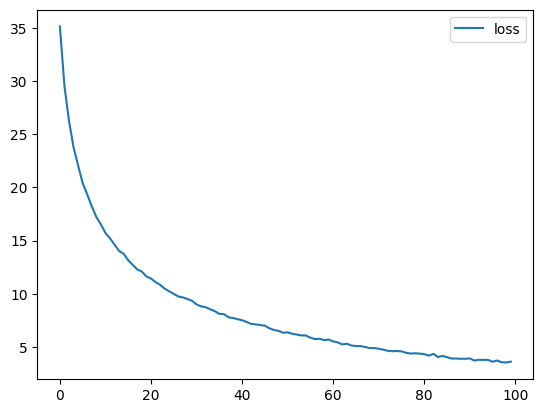

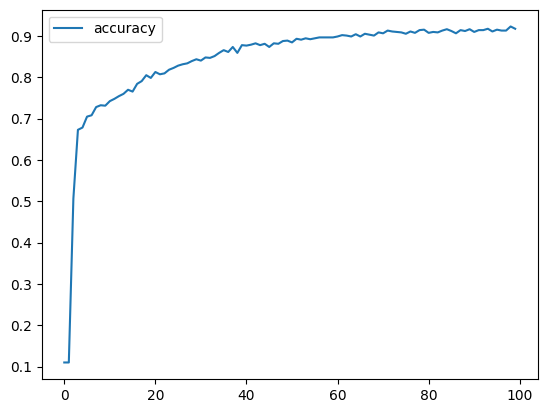

In [ ]:
main1()

## Segmentation

In [ ]:
class FullPCTransSeg(nn.Module):
    def __init__(self,in_channel=3,out_channel=6,points_num=1024,task='classification',version='naive'):
        super(FullPCTransSeg,self).__init__()
        self.in_channel = in_channel
        self.out_channel = out_channel
        self.task = task

        self.embed = NeighborEmbedding(3)
        #self.sg = SampleGroup(in_channel)
        self.sa1 = OffSetAttention(256)
        self.sa2 = OffSetAttention(256)
        self.sa3 = OffSetAttention(256)
        self.sa4 = OffSetAttention(256)

        self.lbr1 = nn.Sequential(
                    nn.Conv1d(in_channels=1280,out_channels=1024,kernel_size=1),
                    nn.BatchNorm1d(1024),
                    nn.ReLU()
                )

        #self.m = nn.MaxPool1d(1024,1)
        #self.avg = nn.MaxPool1d(1024,1)
        # for classification
        self.lbrd1 = nn.Sequential(
                    nn.Conv1d(in_channels=2048,out_channels=256,kernel_size=1),
                    nn.BatchNorm1d(256),
                    nn.ReLU(),
                    nn.Dropout()
                )

        self.lbrd2 = nn.Sequential(
                    nn.Conv1d(in_channels=256,out_channels=256,kernel_size=1),
                    nn.BatchNorm1d(256),
                    nn.ReLU(),
                    nn.Dropout()
                )

        self.l1 = nn.Conv1d(in_channels=256,out_channels=out_channel,kernel_size=1)

        # for segmentation
        self.lbrd3 = nn.Sequential(
                    nn.Conv1d(in_channels=3072,out_channels=256,kernel_size=1),
                    nn.BatchNorm1d(256),
                    nn.ReLU(),
                    nn.Dropout()
                    )

        self.lbrd4 = nn.Sequential(
                    nn.Conv1d(in_channels=3136,out_channels=512,kernel_size=1),
                    nn.BatchNorm1d(512),
                    nn.ReLU(),
                    nn.Dropout()
                )
        self.lbr2 = nn.Sequential(
                    nn.Conv1d(in_channels=512,out_channels=256,kernel_size=1),
                    nn.BatchNorm1d(256),
                    nn.ReLU()
                )
        self.Conv1 = nn.Conv1d(256,self.out_channel,1)

        self.label_lbr = nn.Sequential(
                    nn.Conv1d(in_channels=1,out_channels=64,kernel_size=1),
                    nn.BatchNorm1d(64),
                    nn.ReLU(),
                    )


    def forward(self,x,labels):
        B,C,N = x.size()
        #print(x.size())
        x0 = self.embed(x)# batch,256,256
        x1 = self.sa1(x0)#256
        x2 = self.sa2(x1)
        x3 = self.sa3(x2)
        x4 = self.sa4(x3)#256
        x5 = torch.concatenate((x0,x1,x2,x3,x4),1)#1280
        x6 = self.lbr1(x5)#point feature
        #print(x6.shape)

        x_max = torch.max(x6,dim=-1)[0]
        x_mean = torch.mean(x6,dim=-1)
        x_max_features = x_max.unsqueeze(-1).repeat(1,1,N)
        x_mean_features = x_mean.unsqueeze(-1).repeat(1,1,N)
        # print("x6",x6.shape)
        # print("max",x_max_features.shape)
        # print("labels",labels.shape)
        # print("mean",x_mean_features.shape)
        labels_features = self.label_lbr(labels.view(B,1,-1))
        #print(labels_features.shape)
        x7 = torch.cat([x6.repeat(1,1,4),x_max_features,x_mean_features,labels_features],1)
        #print(x7.shape)
        #print(x7.shape)
        x8 = self.lbrd4(x7)
        x9 = self.lbr2(x8)
        x10 = self.Conv1(x9)
        return x10


In [ ]:
losses = []
accuracy = []
def main():
    NUM_CLASSES = 6
    NUM_FEATURES = 3
    NUM_TRAIN_POINTS = 1024

    TASK = 'segmentation'
    model_save_path = os.path.join(os. getcwd(), 'drive/MyDrive/ROB498/model/best_segmentation_model10_Full_normal.pt')
    learning_rate = 0.001
    Batch_size = 32
    num_epochs = 50
    if TASK=='classification':
      model = FullPCTransCls(NUM_FEATURES,NUM_CLASSES,NUM_TRAIN_POINTS,TASK)
    else:
      model= FullPCTransSeg(NUM_FEATURES,NUM_CLASSES,NUM_TRAIN_POINTS,TASK)
    device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
    #opt = optim.Adam(model.parameters(),learning_rate)
    opt = optim.SGD(model.parameters(),learning_rate,momentum=0.5)
    #path = os.path.join(os.getcwd(),'drive/MyDrive/ROB498/modelnet10_normal_resampled/')
    path = '/content/data/seg/'
    train_dataloader = get_data_loader(path,Batch_size, True)
    test_dataloader = get_data_loader(path,Batch_size, False)

    model = model.to(device)

    best_accuracy = -1
    for epoch in tqdm(range(num_epochs)):
        train_epoch_loss = train(train_dataloader,model,opt,epoch,device,TASK)
        test_accuracy = test(test_dataloader,model,epoch,device,TASK)
        #print(train_epoch_loss)
        losses.append(train_epoch_loss.item())
        accuracy.append(test_accuracy)
        print ("epoch: {}   train loss: {:.4f}   test accuracy: {:.4f}".format(epoch, train_epoch_loss, test_accuracy))
        if test_accuracy>best_accuracy:
           best_accuracy = test_accuracy
           torch.save(model.state_dict(),model_save_path)
    epoches = range(len(losses))
    plt.plot(epoches,losses,label='loss')
    plt.legend()
    plt.show()

    plt.plot(epoches,accuracy,label='accuracy')
    plt.legend()
    plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]

epoch: 0   train loss: 173.2157   test accuracy: 0.7755


  4%|▍         | 2/50 [01:16<29:53, 37.36s/it]

epoch: 1   train loss: 104.4045   test accuracy: 0.8601


  6%|▌         | 3/50 [01:50<27:59, 35.74s/it]

epoch: 2   train loss: 76.6171   test accuracy: 0.9143


  8%|▊         | 4/50 [02:24<26:47, 34.95s/it]

epoch: 3   train loss: 59.8943   test accuracy: 0.9437


 10%|█         | 5/50 [02:57<25:55, 34.56s/it]

epoch: 4   train loss: 48.3590   test accuracy: 0.9555


 12%|█▏        | 6/50 [03:31<25:04, 34.18s/it]

epoch: 5   train loss: 40.1086   test accuracy: 0.9601


 14%|█▍        | 7/50 [04:05<24:27, 34.12s/it]

epoch: 6   train loss: 34.3039   test accuracy: 0.9638


 16%|█▌        | 8/50 [04:39<23:48, 34.02s/it]

epoch: 7   train loss: 30.2492   test accuracy: 0.9702


 18%|█▊        | 9/50 [05:13<23:15, 34.03s/it]

epoch: 8   train loss: 26.8252   test accuracy: 0.9751


 20%|██        | 10/50 [05:46<22:38, 33.96s/it]

epoch: 9   train loss: 24.5645   test accuracy: 0.9766


 22%|██▏       | 11/50 [06:21<22:05, 33.99s/it]

epoch: 10   train loss: 22.1259   test accuracy: 0.9813


 24%|██▍       | 12/50 [06:54<21:25, 33.83s/it]

epoch: 11   train loss: 20.3976   test accuracy: 0.9852


 26%|██▌       | 13/50 [07:28<20:48, 33.73s/it]

epoch: 12   train loss: 18.8696   test accuracy: 0.9875


 28%|██▊       | 14/50 [08:01<20:13, 33.71s/it]

epoch: 13   train loss: 17.6560   test accuracy: 0.9911


 30%|███       | 15/50 [08:35<19:40, 33.72s/it]

epoch: 14   train loss: 16.4341   test accuracy: 0.9905


 32%|███▏      | 16/50 [09:08<19:05, 33.68s/it]

epoch: 15   train loss: 15.4343   test accuracy: 0.9920


 34%|███▍      | 17/50 [09:42<18:32, 33.72s/it]

epoch: 16   train loss: 14.3963   test accuracy: 0.9928


 36%|███▌      | 18/50 [10:16<17:55, 33.62s/it]

epoch: 17   train loss: 13.7968   test accuracy: 0.9928


 38%|███▊      | 19/50 [10:49<17:22, 33.64s/it]

epoch: 18   train loss: 12.9716   test accuracy: 0.9950


 40%|████      | 20/50 [11:23<16:47, 33.59s/it]

epoch: 19   train loss: 12.2417   test accuracy: 0.9953


 42%|████▏     | 21/50 [11:56<16:11, 33.49s/it]

epoch: 20   train loss: 11.5163   test accuracy: 0.9954


 44%|████▍     | 22/50 [12:30<15:37, 33.48s/it]

epoch: 21   train loss: 10.9786   test accuracy: 0.9971


 46%|████▌     | 23/50 [13:03<15:03, 33.45s/it]

epoch: 22   train loss: 10.3663   test accuracy: 0.9971


 48%|████▊     | 24/50 [13:37<14:30, 33.48s/it]

epoch: 23   train loss: 9.9222   test accuracy: 0.9973


 50%|█████     | 25/50 [14:10<13:57, 33.51s/it]

epoch: 24   train loss: 9.4754   test accuracy: 0.9973


 52%|█████▏    | 26/50 [14:44<13:25, 33.56s/it]

epoch: 25   train loss: 8.9120   test accuracy: 0.9980


 54%|█████▍    | 27/50 [15:17<12:53, 33.61s/it]

epoch: 26   train loss: 8.6254   test accuracy: 0.9982


 56%|█████▌    | 28/50 [15:51<12:17, 33.51s/it]

epoch: 27   train loss: 8.2561   test accuracy: 0.9982


 58%|█████▊    | 29/50 [16:25<11:45, 33.58s/it]

epoch: 28   train loss: 7.7816   test accuracy: 0.9984


 60%|██████    | 30/50 [16:58<11:10, 33.54s/it]

epoch: 29   train loss: 7.5459   test accuracy: 0.9982


 62%|██████▏   | 31/50 [17:31<10:37, 33.54s/it]

epoch: 30   train loss: 7.1305   test accuracy: 0.9984


 64%|██████▍   | 32/50 [18:05<10:03, 33.53s/it]

epoch: 31   train loss: 6.9696   test accuracy: 0.9984


 66%|██████▌   | 33/50 [18:38<09:29, 33.48s/it]

epoch: 32   train loss: 7.0705   test accuracy: 0.9980


 68%|██████▊   | 34/50 [19:12<08:56, 33.54s/it]

epoch: 33   train loss: 6.3385   test accuracy: 0.9986


 70%|███████   | 35/50 [19:45<08:21, 33.40s/it]

epoch: 34   train loss: 6.0419   test accuracy: 0.9986


 72%|███████▏  | 36/50 [20:19<07:48, 33.46s/it]

epoch: 35   train loss: 5.7970   test accuracy: 0.9986


 74%|███████▍  | 37/50 [20:52<07:14, 33.45s/it]

epoch: 36   train loss: 5.5967   test accuracy: 0.9987


 76%|███████▌  | 38/50 [21:25<06:39, 33.33s/it]

epoch: 37   train loss: 5.4989   test accuracy: 0.9987


 78%|███████▊  | 39/50 [21:59<06:07, 33.45s/it]

epoch: 38   train loss: 5.3035   test accuracy: 0.9987


 80%|████████  | 40/50 [22:32<05:34, 33.49s/it]

epoch: 39   train loss: 5.0753   test accuracy: 0.9987


 82%|████████▏ | 41/50 [23:06<05:02, 33.58s/it]

epoch: 40   train loss: 4.8116   test accuracy: 0.9987


 84%|████████▍ | 42/50 [23:40<04:28, 33.53s/it]

epoch: 41   train loss: 4.6990   test accuracy: 0.9987


 86%|████████▌ | 43/50 [24:14<03:55, 33.68s/it]

epoch: 42   train loss: 4.4663   test accuracy: 0.9987


 88%|████████▊ | 44/50 [24:47<03:21, 33.60s/it]

epoch: 43   train loss: 4.3703   test accuracy: 0.9987


 90%|█████████ | 45/50 [25:21<02:48, 33.70s/it]

epoch: 44   train loss: 4.2934   test accuracy: 0.9987


 92%|█████████▏| 46/50 [25:54<02:14, 33.59s/it]

epoch: 45   train loss: 4.2424   test accuracy: 0.9987


 94%|█████████▍| 47/50 [26:28<01:40, 33.48s/it]

epoch: 46   train loss: 4.0358   test accuracy: 0.9987


 96%|█████████▌| 48/50 [27:01<01:07, 33.56s/it]

epoch: 47   train loss: 4.0097   test accuracy: 0.9987


 98%|█████████▊| 49/50 [27:35<00:33, 33.60s/it]

epoch: 48   train loss: 3.8022   test accuracy: 0.9987


100%|██████████| 50/50 [28:09<00:00, 33.78s/it]

epoch: 49   train loss: 3.6820   test accuracy: 0.9987


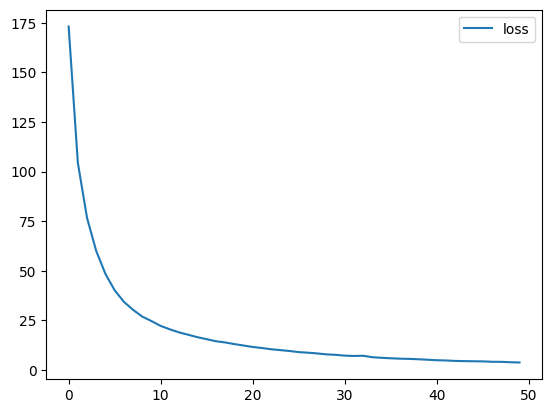

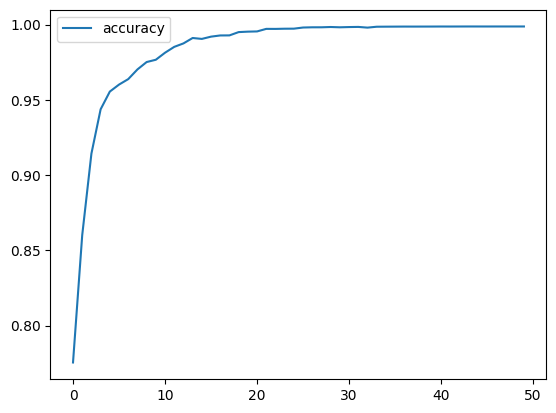

In [ ]:
main()